<a href="https://colab.research.google.com/github/anthonyhu25/Variance-Reduction-Code/blob/main/Variance_Reduction_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from numpy import random
from numpy import linalg
import math
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous, rv_discrete
from scipy.stats._distn_infrastructure import rv_frozen
from scipy.special import logsumexp
import scipy.integrate
import warnings
import sys
import statistics
import pandas as pd
from IPython.display import display, Math, HTML

# 0. Purpose of this document

I seek to implement, as well as give a quick walkthrough of the [Variance Reduction for the Independent Metropolis Sampler](https://arxiv.org/pdf/2406.17699), as well as implementing the control variates for the Independent Metropolis algorithm, and the Adaptive Metropolis algorithm, highlighted in this paper to compare with the results of [On Bayesian inference for the M/G/1 queue with efficient MCMC sampling](https://arxiv.org/pdf/1401.5548) paper.

# 1. Introduction

## Motivation Behind the Method

We are given a target density of the form $\pi(x) = \frac{1}{z}e^{f(x)}$ on some state space $𝕏 ⊂ ℝ^d$, where the normalization constant $z$ is unknown. Assume we would like to estimate a function $F$ with respect to an intractable density $\pi$ -- let us denote it as $𝔼_{\pi}(F) = \int_{𝕏} F(x)\pi(x)\, dx$.

For a Monte Carlo simulation, we draw dependent random variables $X_{i} \sim \pi(x)$ using a MCMC, to produce the unbiased estimator for $𝔼_{\pi}(F)$

$\mu_{n, MC} = \frac{1}{n}\sum_{i=1}^{n} F(X_{i})$

with variance $\sigma^2_{n, MC}$.

The optimal independent Monte Carlo Simulation that minimizes the variance of the estimator when $X_i \stackrel{\mathrm{iid}}{\sim} \pi(x)$ (the moments associated with this estimator are denoted $\mu_{n, MC*}$ and $σ^2_{n, MC*}$ respectively)

Or,

$n\sigma^2_{n,MC} ≥ n\sigma^2_{n,MC*} = 𝔼_{\pi}[(F(x) - 𝔼_{\pi}(F))^2] = \sigma^2_{F}$

Where $\sigma^2_{F}$ is the true variance of F. To reduce the variance of $\sigma^2_{n,MC}$ or $\sigma^2_{n,MC*}$, one method we can use is control variates, if there exists $\left\{ U_i \right\}_{i=1}^{k}$ control variates such that $𝔼_{\pi}(U_{i})$ are analytically available. However, we must use an independent Metropolis sampler to reduce the variance, if such a control variate cannot be computed.

An independent Metropolis estimator can be constructed by using a Markov chain on $𝕏$, with a stationary distribution $\pi(⋅)$ by letting a density $q: 𝕏 → ℝ$ be the transition function/proposal density of the chain.

We propose a new location $y ∈ 𝕏$ to move from the current location $x ∈ 𝕏$ and accept it with probability

$$
\alpha(x, y) :=
\begin{cases}
\min\left(1, \dfrac{\exp(f(y)) \, q(x)}{\exp(f(x)) \, q(y)}\right), & \text{if } \exp(f(x)) \, q(y) > 0 \\
1, & \text{if } \exp(f(x)) \, q(y) = 0
\end{cases}
$$

We construct the ergodic estimator $\mu_{n, IM}$, due to the stationarity and dependent samples $X_{1}, ... , X_{n}$ sampled from the Markov chain, formally defined as

$\mu_{n, IM} = \frac{1}{n}∑_{i=1}^{n}F(X_{i})$


Which, under appropriate conditions, converges using CLT under the form

$$\sqrt{n}(\mu_{n, IM} - 𝔼_{\pi}(F)) = n^{-1/2}∑_{i=1}^{n}(F(X_{i})-𝔼_{\pi}(F)) \xrightarrow{D} N(0, \sigma^2_{IM})$$

Where $\sigma^2_{IM}$ (the asymptotic variance) is given by

$$
\sigma^2_{\text{IM}} := \lim_{n \to \infty}
n \, \mathbb{E}_{\pi}\left[(\mu_{n,\text{IM}} - \mathbb{E}_{\pi}[F])^2\right]
$$



# 2. The Proposed Control Variate for Independent Metropolis algorithm (In Progress)



Suppose the $IM(P, \pi, q)$ is the independent Metropolis algorithm denoted on state space $𝕏 ∈ ℜ^d$ with transition kernel $P$, with corresponding target and proposal densities $\pi(x)$ and $q(y)$.

The transition kernel $P$ is generated by

$P(x, dy) := \alpha(x, y)q(y)dy + (1 - ∫\alpha(x,z)q(z)dz) δ_{x}(dy)$

where $δ_{x}$ is Dirac's measure centered at x. For any function $G: 𝕏 → ℜ$ we have

$ PG(x) := E_{x}(G(X_{1})) := E_{x}(G(X_{1})|X_{0} = x) = ∫P(x, dy)G(y)dy$

$ = \int \alpha(x,y)q(y)G(y)dy + (1 - \int \alpha(x,z)q(z)dz)G(x)$

$ =  G(x) + \int \alpha(x,y)(G(y) - G(x))q(y)dy$.

According to [this paper](https://bibbase.org/network/publication/henderson-variancereductionviaanapproximatingmarkovprocess-1997), $PG(x) - G(X)$ has $0$ expectation with respect to $\pi(⋅)$, so we can use it as a control variate to reduce the variance of

## 2.1 Numerical Examples for Independent Metropolis Sampler


### Example 1 (Normal target distribution with normal distribution and student-t distribution proposals)

In this example, we are estimating the expected value of $F(x) = x$, with the target distribution $\pi(x)\sim N\bigl(x\mid 0,1 )$. We will use two proposal distributions: $N\bigl(y\mid 0,\sigma^2\bigr)$ and a 0-mean student-t distribution with $t_\nu (y)$. Note that $\sigma^2$ and $\nu$ are not fixed in either proposal distribution. We will simulate the posterior with different values of each parameter to see how $\mu_{n,IMCV}$ (the posterior mean of the independent Metropolis-Hastings Algorithm with the control variate for $n$ samples) changes as we increase both parameters.

For each possible values of $\sigma^2$ and $\nu$, we will simulate 5000 values (as noted in the paper) for 20 times. Then, we will find $\mu_{n, MC*}$ (the mean of the conditional Monte Carlo estimator for $n$ samples) of the algorithm, and calculate the VRF (variance reduciton factor) using the below formula:

$$VRF =
  \frac{%
    \displaystyle
    \sum_{i=1}^T
      \Bigl(
        \mu_{n,\mathrm{MC}^*}^{(i)}
        \;-\;
        \frac{1}{T}\,\sum_{j=1}^T \mu_{n,\mathrm{MC}^*}^{(j)}
      \Bigr) ^2
  }{%
    \displaystyle
    \sum_{i=1}^T
      \Bigl(
        \mu_{n,\mathrm{IMCV}}^{(i)}
        \;-\;
        \frac{1}{T}\,\sum_{j=1}^T \mu_{n, \mathrm{IMCV}^*}^{(j)}
      \Bigr) ^2
  }
$$


Note that we need to explicitly calculate $E_{q}(F)$, where $F(x) = x$.
Since $q(y)$ are the $N\bigl(y\mid 0,\sigma^2\bigr)$ and the $0$-mean student-t distribution with $t_\nu (y)$, we just need to find the first moment of these two distributions. However, since both distributions have 0 mean, then $𝔼_{q}(F) = 𝔼_{q}(x) =  0$ for both proposal distributions. Note that $f(x) ∝ \frac{-\mu x^2 }{2σ^2}$, where $\mu$ and $\sigma$ are parameters of $\pi(x)$. So, $f(x)$ simplifies to $\frac{-x^2}{2}$, for all values drawn from $\pi(x)$. Also note that both proposal densities are greater than 0, and hence we do not have to worry about the case when $q(y)$ equals 0.

In [1]:
def univariate_independent_metro(n_simulations, T_iterations, burn_in, pi_distribution, q_distribution, F_function):
  # First check to see if pi and q are both scipy distribution objects
  for name, dist in [("q_distribution", q_distribution), ("pi_distribution", pi_distribution)]:
      if not all(hasattr(dist, attr) for attr in ["rvs", "pdf", "expect"]):
          raise ValueError(
              f"{name} must be a valid frozen scipy.stats distribution with .rvs(), .pdf(), and .expect(). Got: {type(dist)}"
          )
  mu_IMCV_list = []
  mu_MC_list = []
  # Calculate expectation of F with respect to q
  F_q_expect = q_distribution.expect(F_function)
  # Define our F() in this example(which is F(x) = x)
  ## Note: this function is not related to the f(x) function in the alpha acceptance ratio
  for i in range(T_iterations):
    # This is for the state of the chain: Just to keep in track for proposing and sampling new values
    ## It is not really necessary for me to initiate a list for a chain when it comes to calculating mu_IMCV
    ## and mu_MC, but it helps with me for analyzing the movement of the chain in case I coded something wrong
    X_list = []
    Y_list = []
    alpha_chain = []
    # MCMC algorithm: iterate through number of simulations
    for j in range(n_simulations + burn_in):
      if(len(X_list) == 0):
        # Initiate the Chain by Sampling from Proposal Distribution
        X_list.append(float(q_distribution.rvs()))
        Y_list.append(float(q_distribution.rvs()))
        alpha_chain.append(1)
      else:
        # X in each iteration is the current state of the chain.
        X = float(X_list[-1])
        # Y in each iteration is drawn from the proposal density
        Y = float(q_distribution.rvs())
        # Calculate acceptance ratio
        ## find alpha, and then generate uniform distribution to accept or reject the sample
        numerator_alpha = pi_distribution.pdf(Y) * q_distribution.pdf(X)
        denominator_alpha = pi_distribution.pdf(X)* q_distribution.pdf(Y)
        alpha = min(1, numerator_alpha / denominator_alpha)
        # Append Y to the Y_list, for final calculation of the Mu-values
        Y_list.append(Y)
        alpha_chain.append(alpha)
        # Generate uniform RV to accept/reject Y
        ## if U is less than alpha, then we accept new sample(Y) as the next state
        ## Otherwise, we stay at the current state(X)
        u = np.random.uniform(low = 0, high = 1)
        if(u <= alpha):
          X_list.append(Y)
        else:
          X_list.append(X)
      # Throw away the burn-in samples
    X_list = X_list[burn_in:]
    Y_list = Y_list[burn_in:]
    alpha_chain = alpha_chain[burn_in:]
    # Now we calculate the approximations of mu_IMCV and mu_MC
    ## Note that mu_MC is the basic conditional MH algorithm: just feed the chain state (X_i) into the function F() and look for its average
    ## Calculation of mu_IMCV is relatively harder, but still quite simple.
    mu_IMCV = mu_calculation(X_list, Y_list, alpha_chain, is_IMCV = True, F_function = F_function, q_distribution = q_distribution)
    mu_MC = np.mean(F_function(X_list))
    mu_IMCV_list.append(float(mu_IMCV))
    mu_MC_list.append(float(mu_MC))
  return mu_IMCV_list, mu_MC_list, X_list, Y_list, alpha_chain

# Helper function for calculation of mu_IMCV
## Note that q has to be a scipy.stats.___ distribution. Cannot use numpy
def mu_calculation(X_chain, Y_chain, alpha_chain, is_IMCV, F_function, q_distribution):
  # Check to see if q is a scipy distribution
  if not all(hasattr(q_distribution, attr) for attr in ["rvs", "pdf", "expect"]):
      warnings.warn("Warning: q is not a valid scipy.stats frozen distribution.")
      sys.exit(1)
  mu = 0
  F_q_expect = q_distribution.expect(F_function)
  if is_IMCV == True:
    for i in range(len(X_chain)):
      mu += F_function(X_chain[i]) + alpha_chain[i] * (F_function(Y_chain[i]) - F_function(X_chain[i])) - (F_function(Y_chain[i]) - F_q_expect)
    mu = mu / len(X_chain)
  else:
    mu = np.mean([F_function(x) for x in X_chain])
  return mu

  ## Helper function for plotting X_i, Y_i, and alpha(X_i, Y_i)
def plot_traces(X_chain, Y_chain, alpha_chain, q_distribution=None):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(X_chain, label='X Chain')
    axs[0].set_ylabel('X values')
    axs[0].legend()

    axs[1].plot(Y_chain, label='Y Chain', color='orange')
    axs[1].set_ylabel('Y values')
    axs[1].legend()

    axs[2].plot(alpha_chain, label='Alpha', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Alpha values')
    axs[2].legend()

    if q_distribution is not None:
        dist_name = q_distribution.dist.name  # e.g. 'norm' or 't'
        params = ', '.join(f'{k}={v}' for k, v in q_distribution.kwds.items())
        plt.suptitle(f"Trace Plots (q: {dist_name}({params}))", fontsize=14)
    else:
        plt.suptitle("Trace Plots of MCMC Chains", fontsize=14)

    plt.tight_layout()
    plt.show()

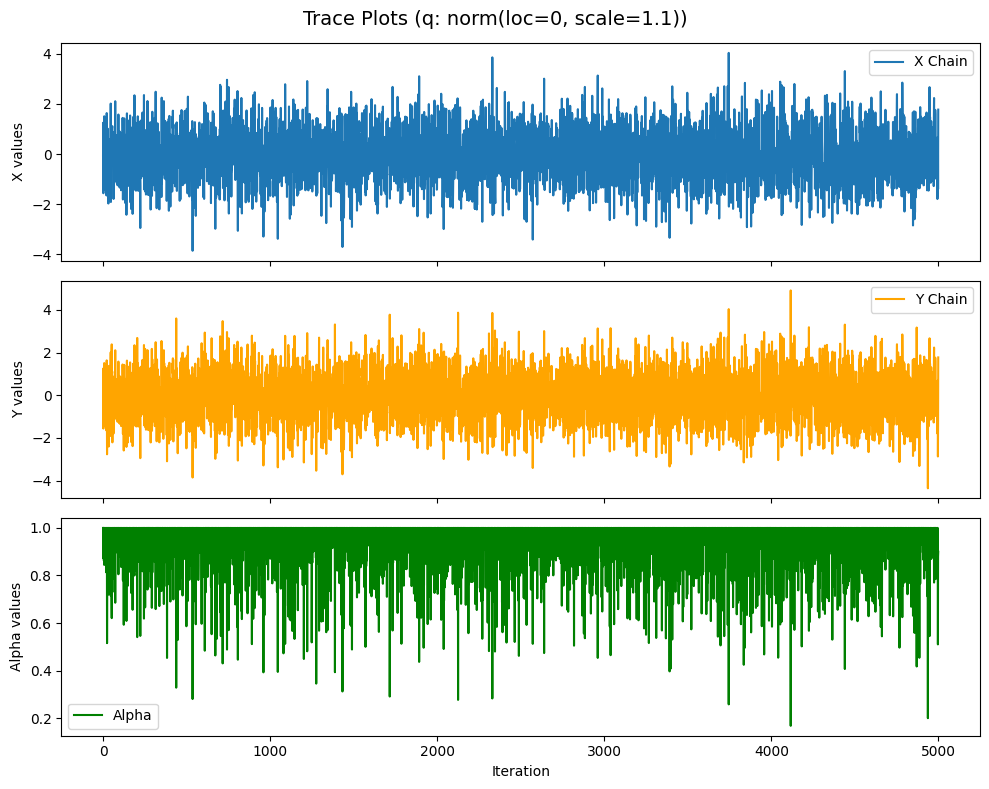

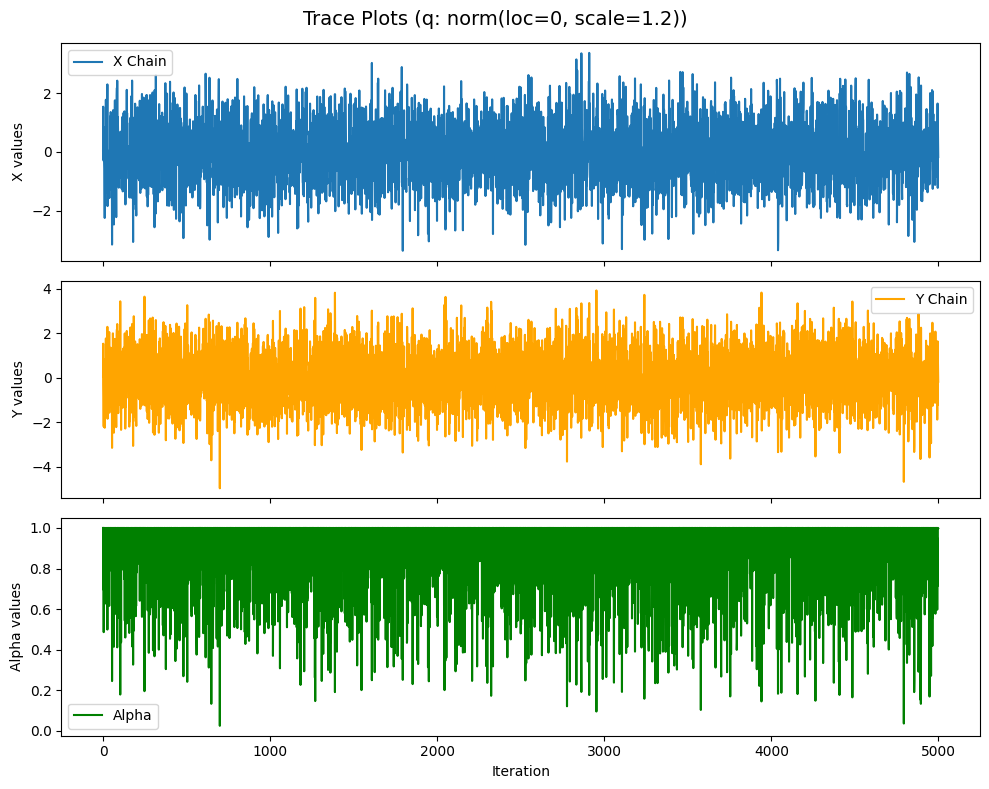

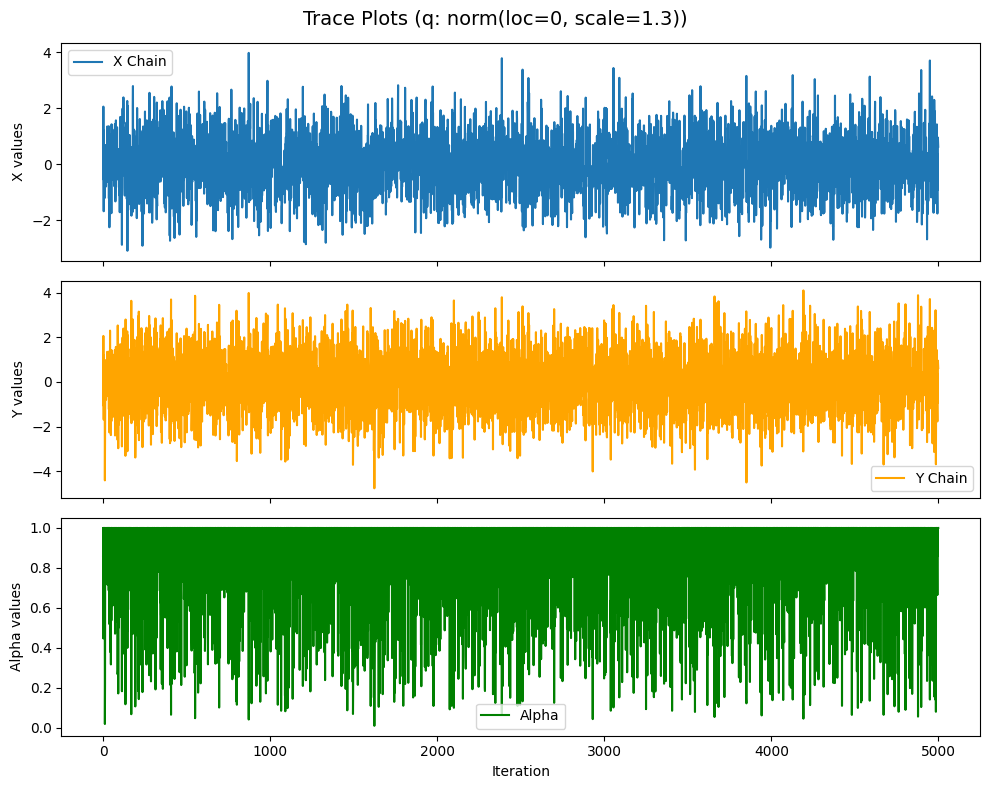

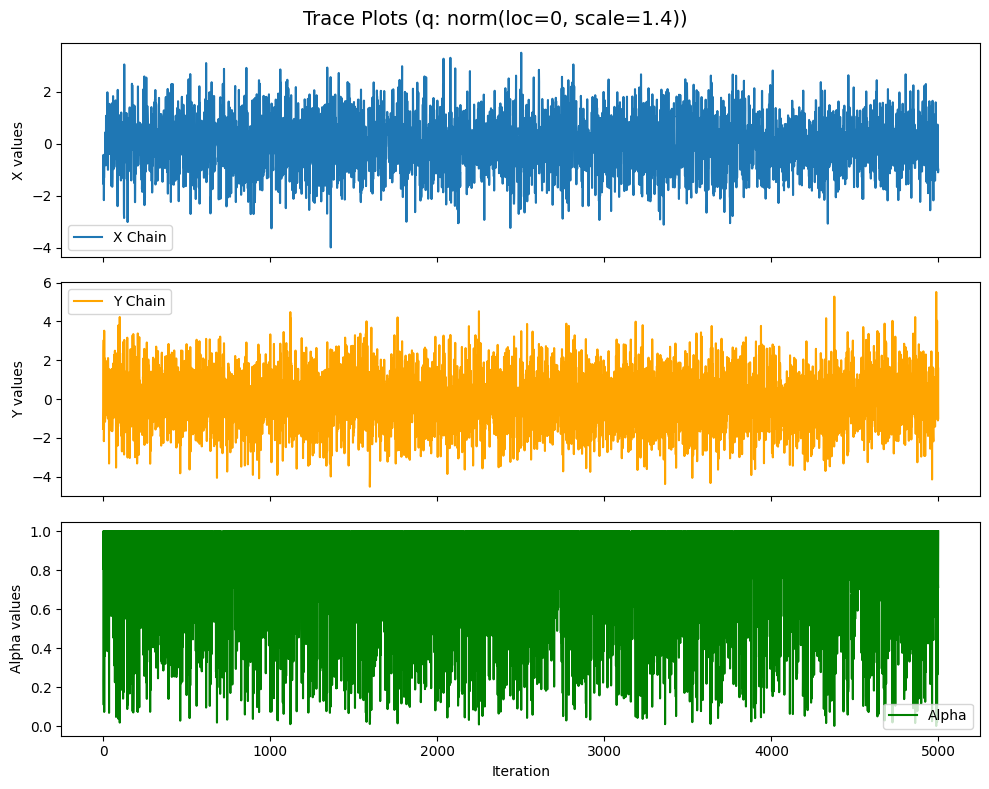

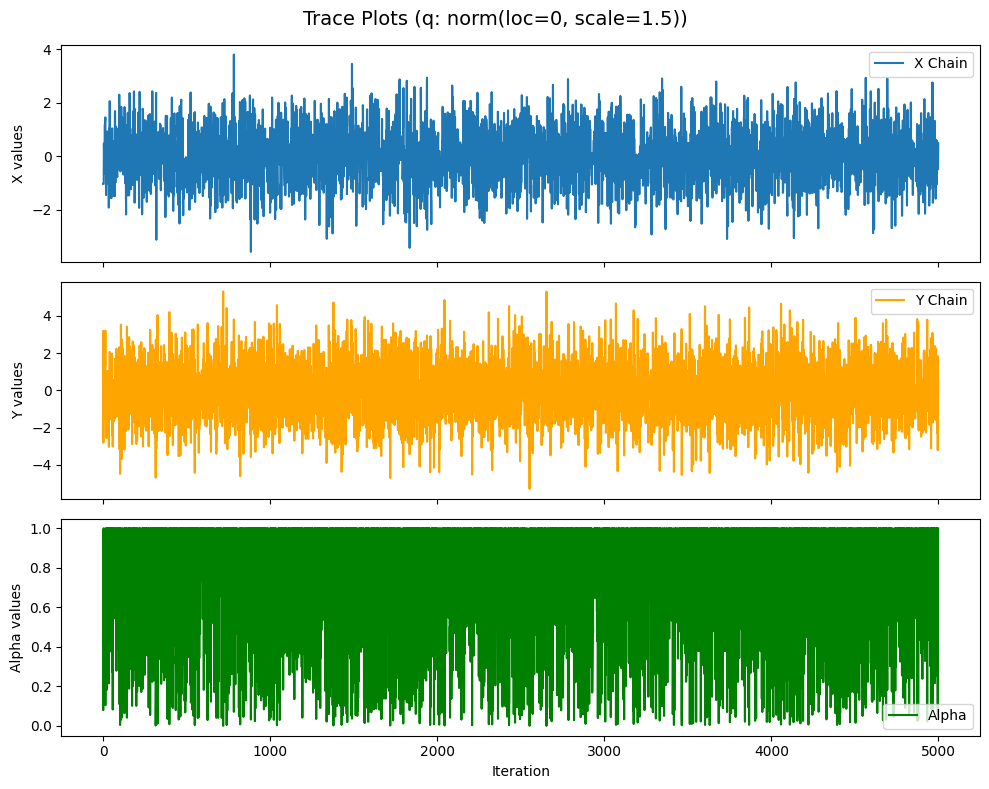

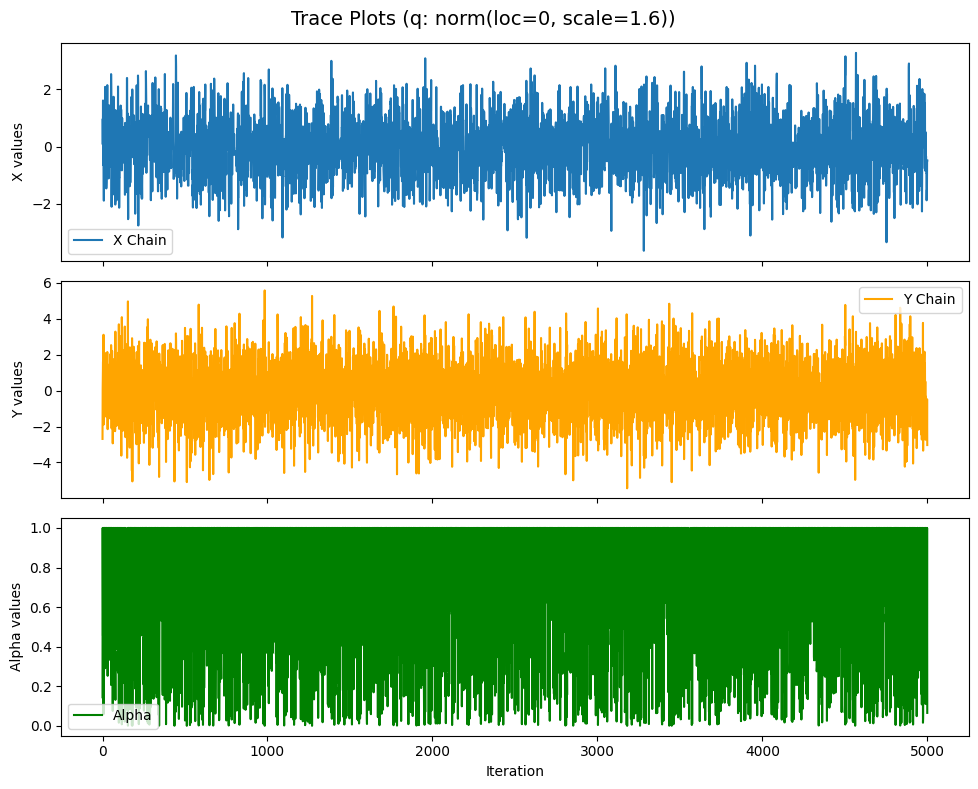

In [8]:
 # Sigmas given in the paper
## Trying to recreate the graphs in the paper to make sure my implementation is correct
sigmas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
IMCV_lists = []
MH_lists = []
VRF_list = []
T = 100
for k in sigmas:
  A = univariate_independent_metro(n_simulations = 5000, T_iterations = T, burn_in = 1000,
                               pi_distribution = scipy.stats.norm(loc = 0, scale = 1),
                               q_distribution = scipy.stats.norm(loc = 0, scale = k),
                               F_function = lambda x: x)
  # It's not necessary to plot these, as they don't have them in the paper, but the more visualizations about how the chain performed, the better in my opinion
  plot_traces(A[2], A[3], A[4], q_distribution = scipy.stats.norm(loc = 0, scale = k))
  # mu_IMCV
  IMCV_lists.append(A[0])
  # mu_MC*
  MH_lists.append(A[1])
  # VRF calculation
  VRF_list.append(statistics.variance(A[1])/statistics.variance(A[0]))

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2600862558.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipython-input-2600862558.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")
/tmp/ipython-input-2600862558.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("$\sigma$")


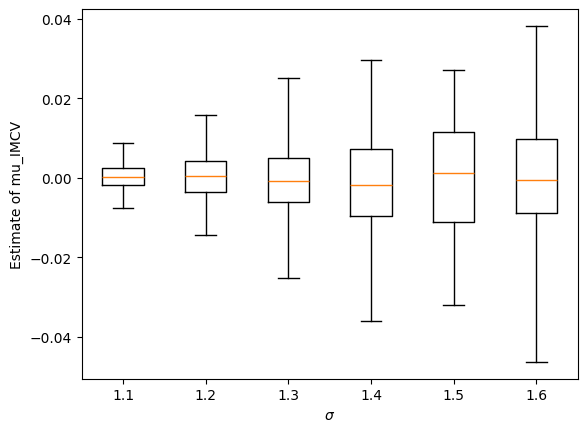

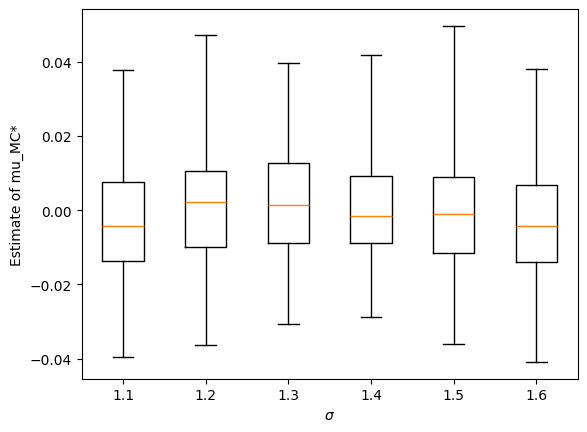

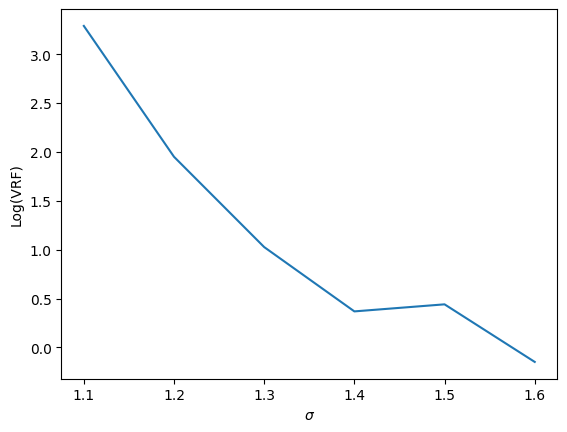

In [9]:
# Plotting the mu_IMCV estimates. In paper
plt.boxplot(IMCV_lists, tick_labels = sigmas, showfliers=False, whis=[0, 100])
plt.xlabel("$\sigma$")
plt.ylabel("Estimate of mu_IMCV")
plt.show()
# Plotting the mu_MC* estimates. Not in the paper, but just for comparison
plt.boxplot(MH_lists, tick_labels = sigmas, showfliers=False, whis=[0, 100])
plt.xlabel("$\sigma$")
plt.ylabel("Estimate of mu_MC*")
plt.show()
# Haven't figured out how to calculate the bounds yet, but I have the curve of the base log(VRF) from the simulations
plt.plot(sigmas, [math.log(i) for i in VRF_list])
plt.xlabel("$\sigma$")
plt.ylabel("Log(VRF)")
plt.show()

Now, we use the same target density $\pi(x) \sim N(x|0, 1)$, but the proposal density is $t_{v}(y)$, which is the student-t distribution centered at 0 and with $v$ degrees of freedom. Note that just like the normal proposal above, $$E_{q}(F) = \int_{-\infty}^{\infty} F(x)q(x)dx = \int_{-\infty}^{\infty} xq(x)dx $$

is the first moment -- $E_{q}(x)$ -- of $q(x)$. Since both proposals distributions are set at 0 mean, this implies that $E_{q}(F)$ is also zero. For comparison of the plots from the ones in the paper, check [this part of the paper](https://arxiv.org/pdf/2406.17699#page=15). Note that I also plotted the normal independent Metropolis-Hastings estimate of the mean for comparison between the variance reduction technique highlighted in the paper, and the normal Metropolis-Hastings algorithm

[3.0314331330207964, 6.062866266041593, 12.125732532083186, 24.251465064166364, 48.50293012833273, 97.00586025666546]


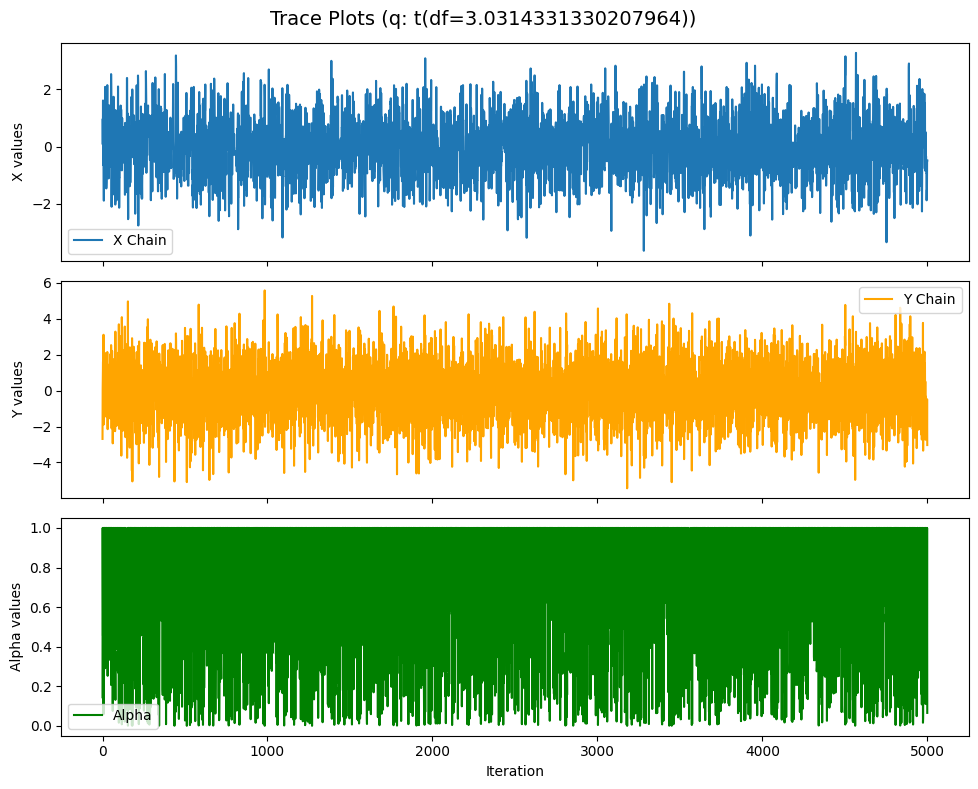

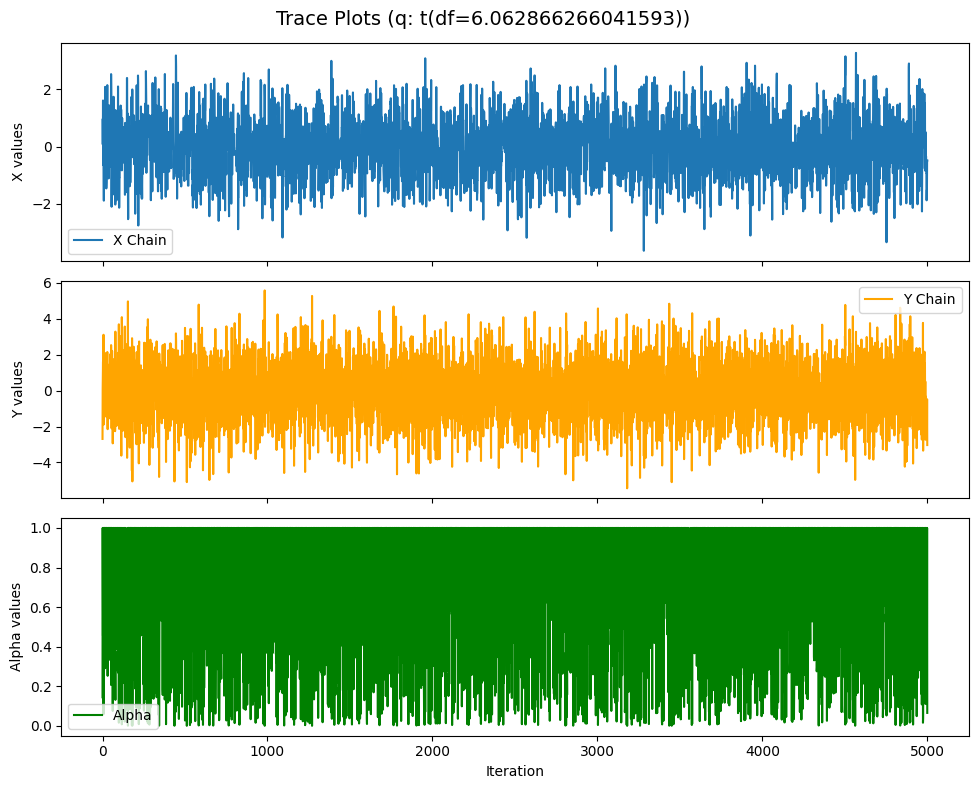

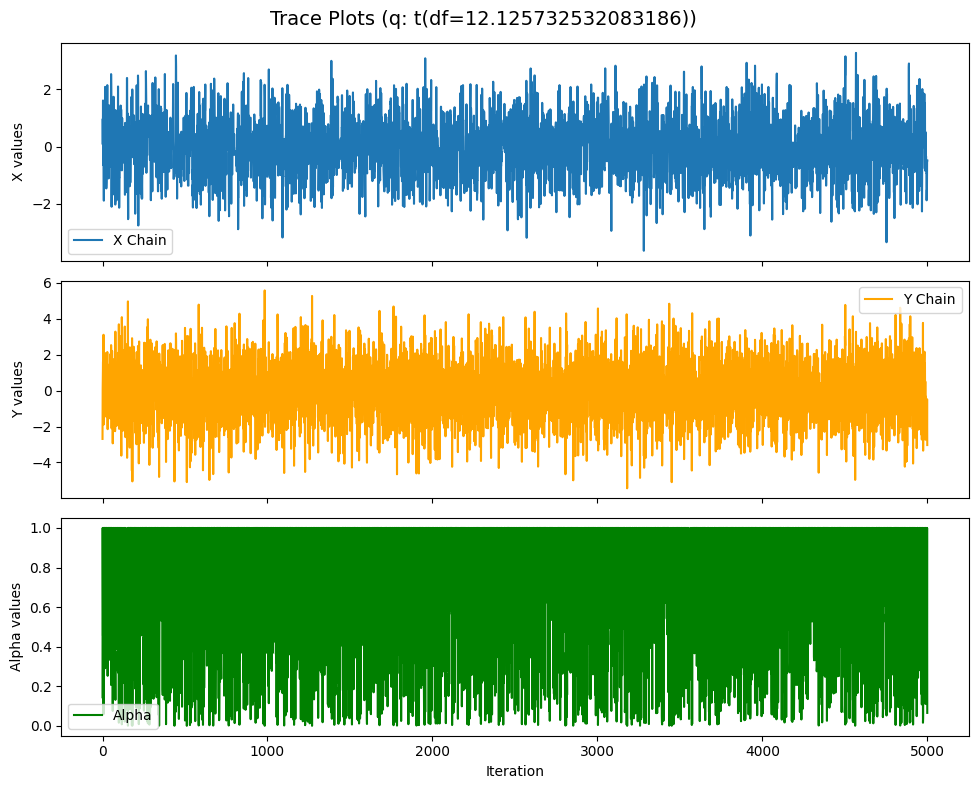

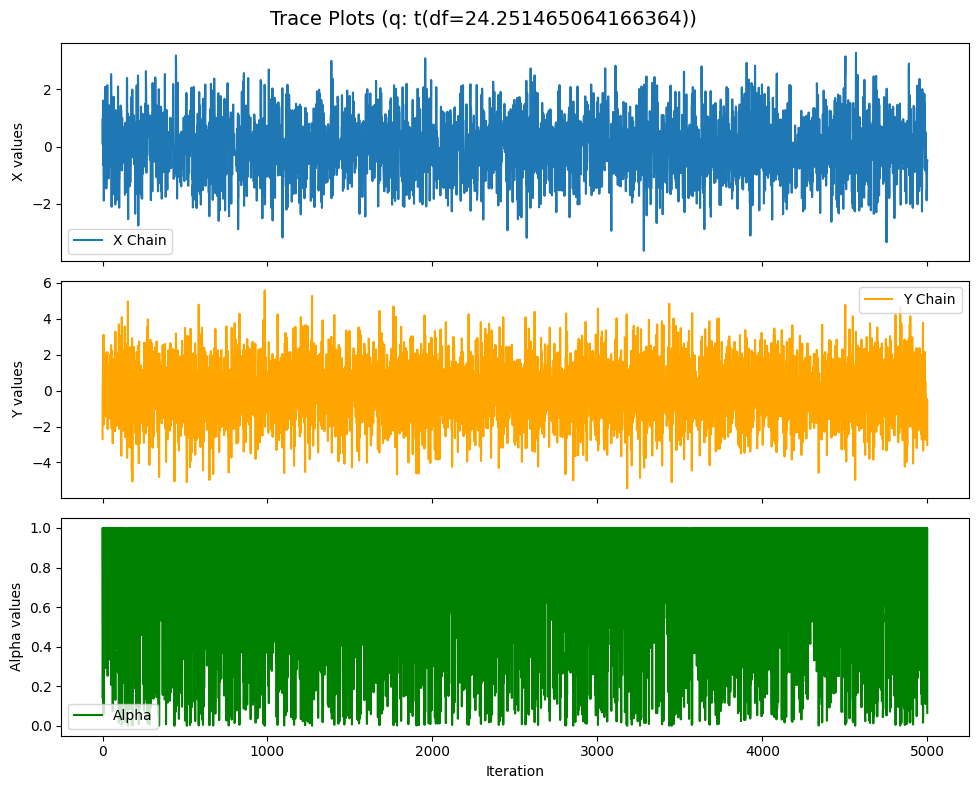

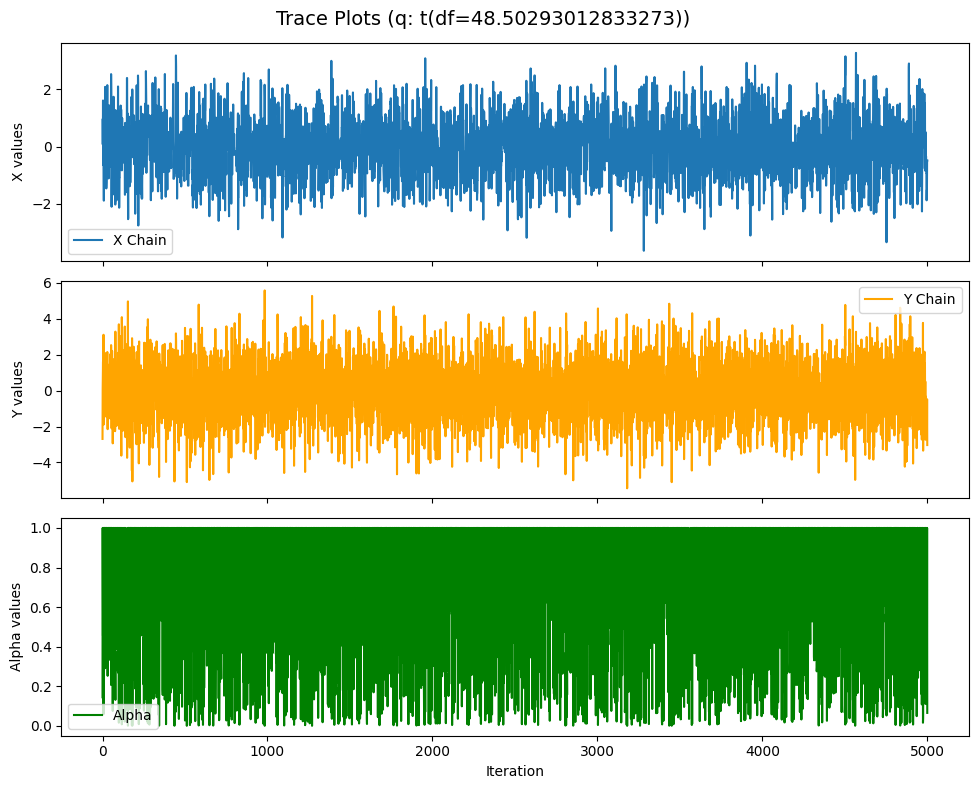

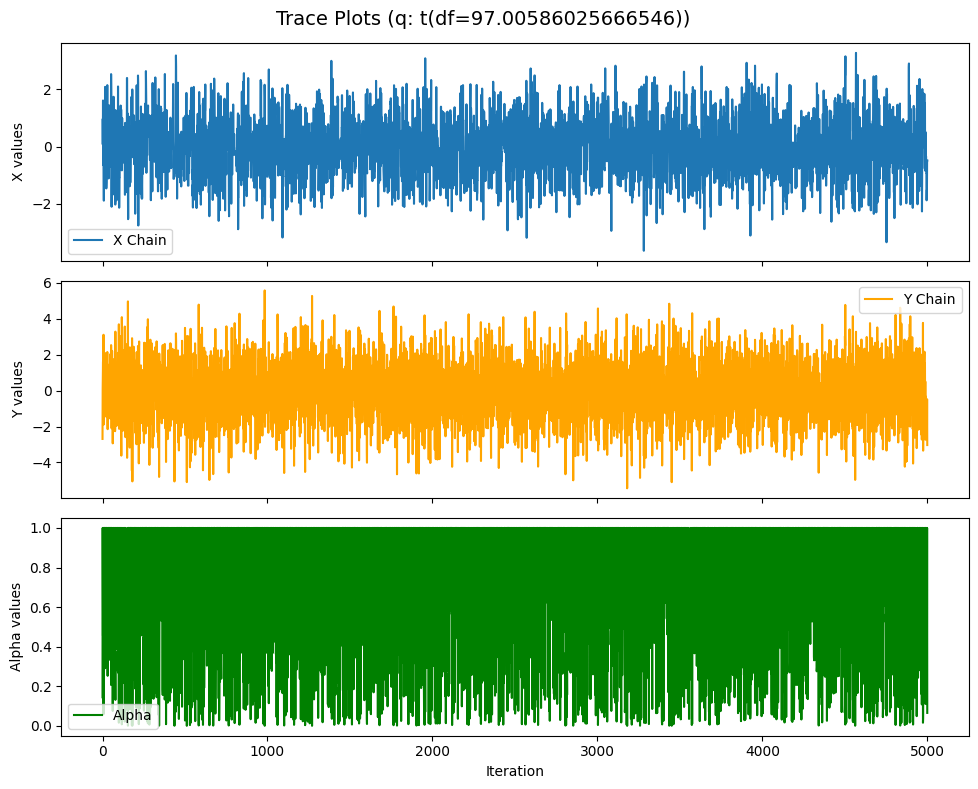

In [10]:
# log_2 of v (degrees of freedom parameters for T-distribution) given in paper
log_2_v = [1.6, 2.6, 3.6, 4.6, 5.6, 6.6]
v = [2 ** i for i in log_2_v]
print(v)
IMCV_t_distribution_lists = []
MH_t_distribution_lists = []
VRF_t_distribution_lists = []
T = 100
for k in v:
  X = univariate_independent_metro(n_simulations = 5000, T_iterations = T, burn_in = 1000,
                               pi_distribution = scipy.stats.norm(loc = 0, scale = 1),
                               q_distribution = scipy.stats.t(df = k),
                               F_function = lambda x: x)
  plot_traces(A[2], A[3], A[4], q_distribution = scipy.stats.t(df = k))
  IMCV_t_distribution_lists.append(X[0])
  MH_t_distribution_lists.append(X[1])
  VRF_t_distribution_lists.append(statistics.variance(X[1])/statistics.variance(X[0]))

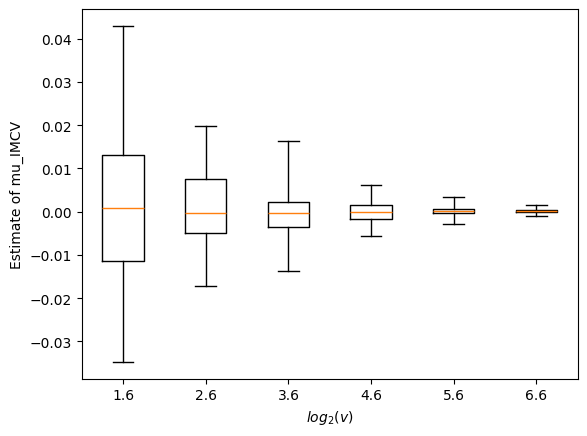

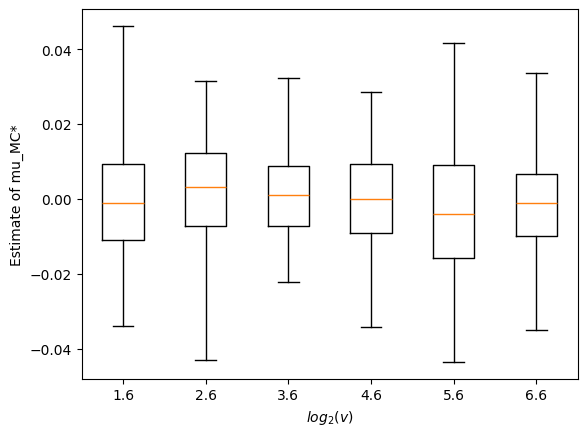

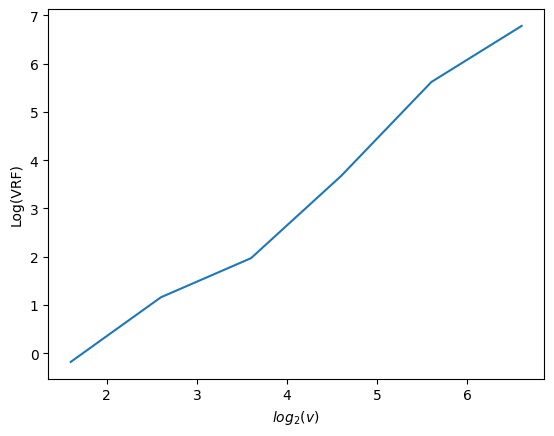

In [11]:
#
plt.boxplot(IMCV_t_distribution_lists, tick_labels = log_2_v, showfliers=False, whis=[0, 100])
plt.xlabel("$log_2(v)$")
plt.ylabel("Estimate of mu_IMCV")
plt.show()

plt.boxplot(MH_t_distribution_lists, tick_labels = log_2_v, showfliers=False, whis=[0, 100])
plt.xlabel("$log_2(v)$")
plt.ylabel("Estimate of mu_MC*")
plt.show()

plt.plot(log_2_v, [math.log(i) for i in VRF_t_distribution_lists])
plt.xlabel("$log_2(v)$")
plt.ylabel("Log(VRF)")
plt.show()

### Example 2: Bayesian model selection in non-conjugate linear regression

Consider $y = Xβ + ϵ$, where $y = (y_{1} ,... , y_{N})$ a column vector of observations, $X$ is an $N \times p$ design matrix, $β = (\beta_{1},...,\beta_{p})$ is a column vector of regression coefficients, and $ϵ \sim N(0, \sigma^2 I_{n})$ is the error vector.

For Bayesian model selection, we seek to calculate posterior model probabilities $f(m|y) \propto f(m)f(y|m)$ for every $m$ specified by $β_{m}$, where we arrange $p$ elements from $β$ with $2^p$ possible sets (the power set) for each design matrix $X_{m}$. So, we need to calculate the marginal likelihood of y with respect to model m, given by $f(y|m) = ∫f(y|m, \beta_{m})f(\beta_{m}|m)dβ_{m}$, such that $f(y|m, \beta_{m})$ is the conditional likelihood function of y on $m$ and $\beta_{m}$, and $f(\beta_{m}|m)$ is the prior density of model $m$.

In this example, we seek to estimate the density of $f(y|m, β_{m})$ analytically. So, we are implicitly finding the expectation of $f(y|m, \beta_{m})$, or $E_{q}(f(y|m, \beta_{m})$ -- in this example, we set the function $F(x) = f(y|m, \beta_{m})$. To do so, note that we have two priors in this example: one on $g$ and one on $\beta_{m}|g, m$. Let N = 50 datapoints, with predictors $X_{i} \sim N(0,1), i = 1,...,4$ and response $Y \sim N(4X_{3} + 4X_{4}, 2.5 ^ 2)$. Suppose we choose a proposal density for $\beta_{m}$ in the form

$$
q(\beta_{m}) = \sum_{i=1}^{K} w_{i}N(\beta_{m}|0, g_{i}(X_{m}^{\top}X_{m})^{-1})
$$

such that $\sum_{i=1}^{K} w_{i} = 1, 0 < w_{i} < 1$

Note that the g-prior is defined as $p(g) = (1+g)^{-2}, g > 0$ in this example.

Quick Note: to sample from the g-prior distribution, there are two ways to do so in Python. The first is to invert its cdf and use a uniform distribution for sampling.  

$F_G(g) = P(G ≤ g) = ∫_{0}^{g}p(g)dg = ∫_{0}^{g}\frac{1}{(1+g)^{-2}}dg = -\frac{1}{1+g}|_{0}^{g} = 1 - \frac{1}{1+g}$

Generate $U \sim Uniform[0,1]$, and set $F_G(g)$ equal to $U$

$U = 1 - \frac{1}{1+g}$

$ 1 - U = \frac{1}{1+g}$

$ 1 + g - U - Ug = 1$

$ g - Ug = g(1-U) = U $

$ g = \frac{U}{1-U}$

So hence, generate $U \sim Uniform[0,1]$, then find $\frac{U}{1-U}$ to generate $g$.

However, with $U$ in the edges of the range (around 0 or 1), this can lead to numerical instability.

The second way, which is the method we will use in this paper, is by simulating the Lomax distribution directly from [scipy](https://scipy.github.io/devdocs/reference/generated/scipy.stats.lomax.html). Note that the distribution of the g-prior is identical to the density of the Lomax distribution, given below as:

$f(x|c) = \frac{c}{(1+x)^{c+1}}$

So the g-prior is actually a Lomax distribution with shape parameter(c) equal to 1.


The numbers for this example will be from the $X_{123}$ model, which means that the first three covariates (1,2,3), denoted as $m$ in the paper, will be used in the model. However, I will run all of the possible covariates combinations for comparison of the algorithm.

In [ ]:
# Initializing the X and Y matrices
## N and p are set from the paper
N = 50
p = 4
# Generate X first
mu = 0
sigma = 1
X_1 = np.random.normal(mu, sigma, size = N)
X_2 = np.random.normal(mu, sigma, size = N)
X_3 = np.random.normal(mu, sigma, size = N)
X_4 = np.random.normal(mu, sigma, size = N)
X = np.column_stack((X_1, X_2, X_3, X_4))
# Generate Y, note the distribution of Y is defined above
y = []
for i in range(len(X_1)):
  Y_i = np.random.normal(loc = 4 * X_3[i] + 4 * X_4[i], scale = 2.5)
  y.append(Y_i)

But first, we need to run an Expectation Maximization algorithm (EM) to estimate the parameters $\{w_i, g_i\}_{j=1}^{K}$ using the following scheme:

(1) Initiate $\{w_i\}_{j=1}^{K}$, where $K$ is the number of distributions (in this example, Gaussians) used to fit the model.  
(2) Sample $g_{j}$ from the g-prior distribution  
(3) Sample $β_{m}$ from a $MVN(0_{m}, gI_{m})$  
(4) Compute responsibilities $$r_{i,j} = \frac{w_j N(x_i|0_{m}, g_{j}I_{m})}
{∑_{l=1}^{K}w_{l} N(x_{i}|0_{m}, g_{l}I{m})}$$   

for $ i = 1, 2, ...., N$ samples and $j = 1, ..., K$ distributions used in the mixture  
(5) Update weights and parameters of the Gaussians:  

$$\hat\mu_{j} = \frac{1}{\sum_{i=1}^{N}r_{i,j}} \sum_{i=1}^{N}r_{i,j}x_{i}$$
$$\hat\Sigma_{j} = \frac{1}{\sum_{i=1}^{N}r_{i,j}} \sum_{i=1}^{N}r_{i,j}(x_{i}-\hat\mu_{j})(x_{i}-\hat\mu_{l})^{T}$$    
$$\hat w_{j} = \frac{1}{N}(\sum_{i=1}^{N}r_{i,j})$$

For $i = 1, ..., N$ datapoints generated from the initial mixture of $j = 1,...,K$ Gaussians.

(5a) Very important note: this paper implicitly assumes that any $\hat\mu_{l}$ remains the $0_{m}$ vector. So this is a special type of EM where the mean vector $\hat\mu_{j}$ does not get updated, which also affects the $\hat Σ_{j}$ updates for all iterations. This is a reasonable assumption to help the EM algorithm converge quickly and theoretically maintain the diagonal nature of every $\hat Σ_{j}$ since every Gaussian is centered at $0_{m}$. However, as we will see in the following EM algorithm, even though this does help drastically improve convergence speed, it is extremely unlikely that the covariance matrices $Σ_{j}$ returned will be a scaled identity matrix, due to the nonzero off-diagonal values and differing diagonal values. I think we can attribute these differences to the variability in the $β_{m}$ sampled, as well as the heavy-tailed distribution when sampling $g_{j}$s from the Lomax distribution. Also, even with these strong assumptions, sometimes large $g_{i}$ values can lead to slow convergence.

If we were to assume the $0_{m}$ vector as the $\hat\mu_{j}$, then we update the parameters in this way:

$$\hatΣ_{j} = \frac{1}{\sum_{i=1}^{N}r_{i,j}} \sum_{i=1}^{N}r_{i,j}x_{i}x_{i}^{T}$$  
$$\hat w_{j} = \frac{1}{N}(\sum_{i=1}^{N}r_{i,j})$$

Note that $β_{m}^{̃}$ is implicitly a vector of iid Gaussians with the distribution $N(0, g)$ for each component of the vector. Also, the EM algorithm also implicitly updates $g_{i}$ by updating the associated matrix $\Sigma_{i} = g_{i}I_{m}$ in the multivariate EM step.

In [ ]:
## Will not use this code for generating g-priors
# def g_distribution(U):
#     epsilon = 1e-6  # or 1e-8
#     U = np.clip(U, epsilon, 1 - epsilon)
#     return U / (1 - U)

# Can use clipping mechanism for generating g-priors to help with numerical stability
## If g_is generated are either too large to too small, then this could lead to degenerate covariance matrix (especially with smaller g_is)
#def bounded_lomax_rvs(size, c=1, g_min=1e-3, g_max=1e2):
    #g = scipy.stats.lomax(c=c).rvs(size=size)
    #return np.clip(g, g_min, g_max)

# Wrap as a callable sampler
#g_sampler = lambda size: bounded_lomax_rvs(size=size, c=1, g_min=1e-3, g_max=1e2)

def beta_generation(N, g_prior_function, m):
  betas = []
  g = []
  for i in range(N):
    # If prior function is a scipy frozen RV. can directly sample from its RVs attribute call
    if isinstance(g_prior_function, rv_frozen):
      # Generate g prior first
      g_i = g_prior_function.rvs(size = 1)
      # Then generate beats
      beta_i = np.random.multivariate_normal(mean = [0 for i in range(len(m))],
                                           cov = g_i * np.identity(len(m)))
      betas.append(beta_i.tolist())
      g.append(g_i)
    else:
    # Otherwise, use a custom g prior function (used for clipping), and have to use correct function calls for that
      g_i = g_prior_function(size = 1)
      beta_i = np.random.multivariate_normal(mean = [0 for i in range(len(m))],
                                           cov = g_i * np.identity(len(m)))
      betas.append(beta_i.tolist())
      g.append(g_i)
    # sample beta from multivariate normal, with 0 mean and gI(m) covariance matrix

  # 1st element is the simulated betas, 2nd element is the simulated g values
  return betas, g

In [ ]:
# Note that m is given as a string in this argument. This matches with the notation in the paper
# if m = "123", then variables 1, 2, and 3 are chosen as the data matrix
m = "123"
A = beta_generation(1000, scipy.stats.lomax(c=1), m)

# In this example, K(number of Gaussians to generate conditional distribution of Beta_m) is equal to 4
K = 4

In [ ]:
def EM_algorithm_Gaussians(K, list_betas, p, g_sampler, N_iterations, update_mu, print_iteration_weights,
                           init_means=None, init_covs=None):
    for i in range(len(list_betas)):
      if len(list_betas[i]) != p:
        warnings.warn("Dimensions of betas and p do not match.")
        sys.exit(1)
    w_i = np.random.dirichlet(np.ones(K)).tolist()
    initial_g_i = w_i.copy()
    if init_means is not None:
      mu_list = init_means
    else:
      mu_list = [[0 for _ in range(p)] for _ in range(K)]
    if init_covs is not None:
      sigma_list = init_covs
    elif isinstance(g_sampler, rv_frozen):
      g_i = g_sampler.rvs(size = K)
      initial_g_i = g_i
      sigma_list = [g * np.identity(p) for g in g_i]
    else:
      g_i = g_sampler(K)
      initial_g_i = g_i
      sigma_list = [g * np.identity(p) for g in g_i]
    for v in range(N_iterations):
      # E Step: calculate responsibilities
      responsibilities = np.empty(shape=(len(list_betas), K))
      # For the generated list of betas, find the responsibilities for each Gaussian variable indexed by j
      for i in range(len(list_betas)):
        beta_i = list_betas[i]
        # adding in log likelihood calculation for numerical stability
        log_likelihoods = [
          math.log(w_i[j]) + scipy.stats.multivariate_normal.logpdf(
              beta_i, mean=mu_list[j], cov=sigma_list[j], allow_singular=True
          )
          for j in range(K)
      ]
        denom = logsumexp(log_likelihoods)
        for j in range(K):
          # calculating new responsibilities
          responsibilities[i][j] = math.exp(log_likelihoods[j] - denom)
      # M step: update parameters based on responsibilities
      for i in range(K):
        r_i = responsibilities[:, i]
        total_r_i = np.sum(r_i)
        if update_mu == True:
          # Mu calculation
          mu_loop = np.sum([
              r_i[j] * np.array(list_betas[j]) for j in range(len(list_betas))
          ], axis=0) / total_r_i
          mu_list[i] = mu_loop
          # Sigma calculation based on new mu
          sigma_list[i] = sum([
            r_i[j] * np.outer(np.array(list_betas[j]) - mu_loop, np.array(list_betas[j]) - mu_loop)
            for j in range(len(list_betas))]) / total_r_i
        else:
          # If update mu is false, then we only calculate and update sigma
          sigma_list[i] = sum([
            r_i[j] * np.outer(np.array(list_betas[j]), np.array(list_betas[j]))
            for j in range(len(list_betas))]) / total_r_i
      # Recalculate the weights
      w_i = [float(np.sum(responsibilities[:, i]) / len(list_betas)) for i in range(K)]
      if print_iteration_weights == True:
        print(f"Iteration {v+1}: Weights: {w_i}")
    # Return final weights, mus, sigmas, initial g_i (from dirichlet prior), and final g_i
    return w_i, mu_list, sigma_list, initial_g_i, g_i

In [ ]:
# EM scheme with updating mu
update_mu_results = EM_algorithm_Gaussians(K, A[0], len(m), scipy.stats.lomax(c=1), 100, True, True)
print(f"Final weights:{update_mu_results[0]}")
print(f"Final mean vectors{update_mu_results[1]}")
print(f"Final covariance matrices{update_mu_results[2]}")
print(f"initial g_i:{update_mu_results[3]}")
print(f"Final_g_i: {update_mu_results[4]}")

Iteration 1: Weights: [0.19225818838541156, 0.06507417386502451, 0.3073848925336979, 0.4352827452158661]
Iteration 2: Weights: [0.1644534967696726, 0.06912450202465106, 0.3064801035594892, 0.4599418976461872]
Iteration 3: Weights: [0.14978648045436804, 0.07331521725811325, 0.3051906994213981, 0.4717076028661205]
Iteration 4: Weights: [0.1396931594026773, 0.07917123806715828, 0.3049660627921479, 0.4761695397380165]
Iteration 5: Weights: [0.13186218883455791, 0.08695748867855906, 0.3047277107630682, 0.4764526117238148]
Iteration 6: Weights: [0.12530660125879223, 0.09663983687024648, 0.30399156103204256, 0.4740620008389187]
Iteration 7: Weights: [0.11952069738251678, 0.1081159811014758, 0.30255675559671097, 0.4698065659192965]
Iteration 8: Weights: [0.11421330615045394, 0.12127206156575036, 0.3003467041988882, 0.46416792808490753]
Iteration 9: Weights: [0.10920246073910249, 0.13599156485061428, 0.2973504272075421, 0.4574555472027411]
Iteration 10: Weights: [0.10437231196984562, 0.15215143

In [ ]:
## This is the EM scheme without updating mu
## This is an example where the EM algorithm has a comparatively "slow" convergence (taking about 20 iterations to converge to the weights)
no_update_mu_results = EM_algorithm_Gaussians(K, A[0], len(m), scipy.stats.lomax(c=1), 40, True, True)
print(f"Final weights:{no_update_mu_results[0]}")
print(f"Final mean vectors{no_update_mu_results[1]}")
print(f"Final covariance matrices{no_update_mu_results[2]}")
print(f"initial g_j:{no_update_mu_results[3]}")

Iteration 1: Weights: [0.24397353376112887, 0.12612970242985452, 0.3553543267456777, 0.274542437063339]
Iteration 2: Weights: [0.24526676688947607, 0.1136982634113205, 0.3661172286174334, 0.27491774108177003]
Iteration 3: Weights: [0.24184343469662586, 0.09469141874731926, 0.3689927453547693, 0.2944724012012855]
Iteration 4: Weights: [0.23623400110731418, 0.07716823675630197, 0.3657034787308336, 0.32089428340555026]
Iteration 5: Weights: [0.2309110983277104, 0.06478315597381863, 0.36112160436952295, 0.3431841413289479]
Iteration 6: Weights: [0.22692084655409356, 0.056973825181201136, 0.35748030640359635, 0.35862502186110895]
Iteration 7: Weights: [0.22450273312723937, 0.052213699520531204, 0.35504292133113435, 0.3682406460210951]
Iteration 8: Weights: [0.22379382274783535, 0.049276296325545386, 0.3534578722165684, 0.37347200871005093]
Iteration 9: Weights: [0.2250928195085276, 0.0473964333940505, 0.35224449519815076, 0.37526625189927115]
Iteration 10: Weights: [0.22888166854770728, 0.0

It seems that we need further add assumptions to recover the $\hat\Sigma_{j}= \hat g_{i}I_{(m)}$ covariance structure in the EM algorithm. Although I can see that the $\hat\Sigma_{j}$ covariance matrices have similar diagonal elements and relatively small non-diagonal values, I still cannot infer what $\hat g_{i}$ is from each $\hat \Sigma_{j}$. We can still sample from the covariance matrices $\Sigma_{j}$, but the proposal density would now take the form of $q(\hatβ) = \sum_{j=1}^{K} \hat w_{j}N(\hatβ|0, \hat\Sigma_{j})$, and perform the same linear transformation $\beta_{m} = (X_{m}^{T}X_{m})^{-\frac{1}{2}}\hat β$ to obtain the estimates of the coefficients.

Here, I will derive the necessary steps for the M-step of this algorithm, from the joint log-likelihood of the EM algorithm, in order to enforce the $\hat g_{i}I_{(m)}$ structure.

Let $𝓛(g_{j})$ be the joint log-likelihood of the datapoints, conditional on the fact that the covariance matrix for the Gaussian is $g_{j}I_{(m)}$.

$$𝓛(g_{j}) = \sum_{i=1}^{N}r_{ij} log N(β_{i}|\mu_{j} = 0_{m}, g_{j}I_{(m)})$$

$$= \sum_{i=1}^{N} r_{ij} log[(2π)^{-m/2} |g_{j}I_{m}|^{-1/2}exp(-\frac{1}{2}\beta_{i}^{T}(g_{j}I_{m})^{-1}\beta_{i})]$$

$$ = \sum_{i=1}^{N} r_{ij} [-\frac{m}{2}log(2\pi g_{j}) - \frac{1}{2g_{j}}\beta_{i}^{T}\beta_{i}]$$

$$ = -\frac{m}{2}log(2\pi g_{j})(\sum_{i=1}^{N} r_{ij}) - \frac{1}{2g_{j}}\sum_{i=1}^{N}r_{ij}||\beta_{i}||^{2}$$

Take derivative with respect to $g_{j}$ and set to 0 to solve for $\hat g_{j}$

$$\frac{d𝓛(g_{j})}{dg_{j}} = -\frac{m}{2g_{j}}\sum_{i=1}^{N}r_{ij} + \frac{1}{2g_{j}^{2}}\sum_{i=1}^{N}r_{ij}||β_{i}||^{2} = 0$$

$$ -mg_{j}\sum_{i=1}^{N}r_{ij} + \sum_{i=1}^{N}r_{ij}||β_{i}||^{2} = 0$$

$$\hat g_{j} = \frac{\sum_{i=1}^{N}r_{ij}||β_{i}||^{2}}{m\sum_{i=1}^{N}r_{ij}}$$

Now, instead of updating $\Sigma_{j}$, we use this to update $g_{j}$ and maintain the diagonal structure of the $\Sigma_{j}$, as it was presented in the paper.

I will write a new EM algorithm below for the change. Note that I will also add some quality of life changes (sometimes depending on the values drawn from the priors I can have extremely small values for $g_{i}$ or $N(0, gI_{m})$. So I will use the log trick(adding log to the expression and then exponentiate to cancel out the log) for numerical stability purposes.

In [ ]:
def EM_algorithm_Gaussians_diagonal_matrix(K, list_betas, p, g_sampler, N_iterations, update_mu, only_print_final = False,
                           init_means=None, init_covs=None):
    for i in range(len(list_betas)):
        if len(list_betas[i]) != p:
            warnings.warn("Dimensions of betas and p do not match.")
            sys.exit(1)
    w_i = np.random.dirichlet(np.ones(K)).tolist()
    initial_w_i = w_i.copy()
    g_i = [0 for _ in range(K)]
    # Log Likelihood list for convergence diagnostics -- should always be nondecreasing
    log_likelihoods_list = []
    if init_means is not None and len(init_means) == K:
        mu_list = init_means
    elif init_means is not None and len(init_means) != K:
        warnings.warn("Number of means and K do not match.")
        sys.exit(1)
    else:
        mu_list = [[0 for _ in range(p)] for _ in range(K)]
    if init_covs is not None:
        sigma_list = init_covs
    elif hasattr(g_sampler, "rvs"):
        g_i = g_sampler.rvs(size = K)
        sigma_list = [g * np.identity(p) for g in g_i]
    else:
        g_i = g_sampler(K)
        sigma_list = [g * np.identity(p) for g in g_i]
    # Initialize the initial g_i for comparison of algorithm
    initial_g_i = g_i.copy()
    for v in range(N_iterations):
      ## Adding total log_likelihood counter for measure of model performance
        ll_total = 0.0
        responsibilities = np.empty(shape=(len(list_betas), K))
        # E-step
        for i in range(len(list_betas)):
          # initiate beta
            beta_i = list_betas[i]
          # calculate likelihoods
          ## using log likelihood for numerical stability purposes
          ### Indeterminate values when calculating EM, especially when g is small, due to abnormally large or small PDFs, which can cause 0-near or
          ### super-large denominators. This in turn causes NAN values, which causes issues with the algorithm
            log_likelihoods = [
                math.log(w_i[j]) + scipy.stats.multivariate_normal.logpdf(
                    beta_i, mean=mu_list[j], cov=sigma_list[j], allow_singular=True
                )
                for j in range(K)
            ]
            denom = scipy.special.logsumexp(log_likelihoods)
            ll_total += denom
            for j in range(K):
              # Exponentiate to remove the log.
              responsibilities[i][j] = math.exp(log_likelihoods[j] - denom)
        # M-step
        for i in range(K):
            r_i = responsibilities[:, i]
            total_r_i = np.sum(r_i)
            if update_mu == True:
              # Calculate Mus
              mu_new = np.sum([
                  r_i[j] * np.array(list_betas[j]) for j in range(len(list_betas))
              ], axis=0) / total_r_i
              mu_list[i] = mu_new
              # Calculate g_is based on new mus, and previously outlined algorithm
              g_hat_new = np.sum([r_i[j] * np.linalg.norm(np.array(list_betas[j]) - mu_new) ** 2 for j in range(len(list_betas))]) / (p * total_r_i)
              g_i[i] = g_hat_new
              # recalculate sigmas
              sigma_list[i] = g_hat_new * np.identity(p)
            else:
              # No update mu -- just calculate sigmas and g_is
              g_hat_new = np.sum([r_i[j] * np.linalg.norm(np.array(list_betas[j])) ** 2 for j in range(len(list_betas))]) / (p * total_r_i)
              g_i[i] = g_hat_new
              sigma_list[i] = g_hat_new * np.identity(p)
        # Recalculate weights
        w_i = [float(np.sum(responsibilities[:, i]) / len(list_betas)) for i in range(K)]
        if only_print_final == False:
          # print weights at each iteration of process
          print(f"Iteration {v+1}: Weights: {w_i}: Log Likelihood: {ll_total}")
          log_likelihoods_list.append(np.float64(ll_total))
        else:
          # Print only last step
          if v == N_iterations - 1:
            print(f"Iteration {v+1}: Final Weights: {w_i}: Log Likelihood : {ll_total}")
            log_likelihoods_list.append(np.float64(ll_total))
    # Return final weights, initial weights, list of vector of mu, initial g_i (sampled from g-prior),
    ## Final g_prior calculated from EM, and log-likelihood list (for convergence and debugging purposes)
    return w_i, initial_w_i, mu_list, initial_g_i, g_i, log_likelihoods_list

Iteration 1: Weights: [0.04596114861182254, 0.013452874194792122, 0.6793185550130835, 0.26126742218030186]: Log Likelihood: -6293.354278911096
Iteration 2: Weights: [0.0982207849973058, 0.014560648887479082, 0.7073902152066138, 0.17982835090860136]: Log Likelihood: -5525.3908297142425
Iteration 3: Weights: [0.17597560862605663, 0.0148986563734194, 0.696288835847102, 0.11283689915342206]: Log Likelihood: -5396.954185907128
Iteration 4: Weights: [0.24569645765861048, 0.014795130639784587, 0.6677034123947849, 0.07180499930682008]: Log Likelihood: -5294.419615993162
Iteration 5: Weights: [0.29364588633025496, 0.015002167105723437, 0.6401620210505349, 0.05118992551348661]: Log Likelihood: -5233.723423753343
Iteration 6: Weights: [0.3237270493003208, 0.016034946723248723, 0.6181564768018024, 0.04208152717462802]: Log Likelihood: -5204.828103430715
Iteration 7: Weights: [0.34341231498651564, 0.017970665246268353, 0.6000413995728202, 0.03857562019439584]: Log Likelihood: -5192.007774399351
Ite

Text(0, 0.5, 'Log Likelihood')

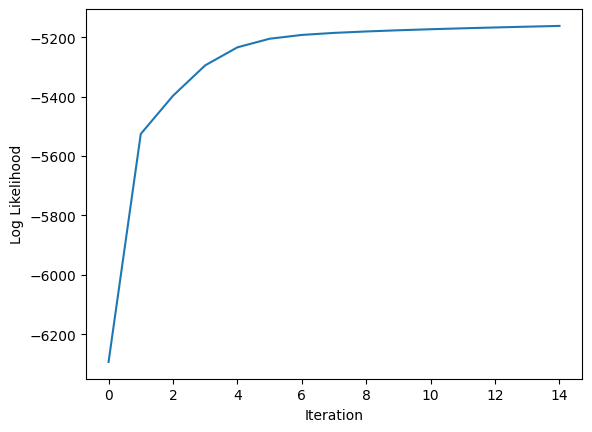

In [ ]:
no_update_mu_diagonal_sigma = EM_algorithm_Gaussians_diagonal_matrix(K, A[0], len(m), scipy.stats.lomax(c=1), 15, False)
print(f"Final weights:{no_update_mu_diagonal_sigma[0]}")
print(f"Initial weights: {no_update_mu_diagonal_sigma[1]}")
print(f"Final mean vectors: {no_update_mu_diagonal_sigma[2]}")
print(f"initial g_j: {no_update_mu_diagonal_sigma[3]}")
print(f"final g_j: {no_update_mu_diagonal_sigma[4]}")
# Plot the log likelihood as it is calculated through iterations
plt.plot(no_update_mu_diagonal_sigma[5])
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

Now, we are ready to run the Independent Metropolis-Hastings algorithm. Again, note that our proposal density is noted as $q(\hatβ) = \sum_{j=1}^{K} \hat w_{j}N(\hatβ|0, \hat g_{i}I_{(m)})$ from the EM algorithm, with estimates $\{\hat w_j, \hat g_j\}_{j=1}^{K}$. Then, we use the transformation $\beta_{m} = (X_{m}^{T}X_{m})^{-\frac{1}{2}}\hat\beta_{m}$ to obtain the estimates of the coefficients.

We hope that these proposed samples matches the priors given below:

$$\beta_{m}|g, m \sim N(0, g(X_{m}^{T}X_{m})^{-1}) , p(g) = (1+g)^{-2}, g > 0$$

So $\pi(x)$, the target density in this example, is the conditional prior distribution of $\beta_{m}$. So for each proposed sample $y$ and current sample $x$ in the MCMC, the acceptance ratio will be:

$$\alpha(x, y) = min (1, \frac{f_{\beta_{m}}(y|m)q_{\beta_{m}}(x)}{f_{\beta_{m}}(x|m)q_{\beta_{m}}(y)} ) = min(1, \frac{f_{\beta_{m}}(y|m)(X_{m}^{T}X_{m})^{-1}q_{\hatβ_{m}}(x)}{f_{\beta_{m}}(x|m)(X_{m}^{T}X_{m})^{-1}q_{\hat\beta_{m}}(y)}= min(1, \frac{f_{\beta_{m}}(y|m) (X^{T}_{m}X_{m})^{-1/2} \sum_{j=1}^{K} \hat w_{j} N(x|0_{m}, \hat g_{j}I_{(m)} )}{f_{\beta_{m}}(x|m) (X^{T}_{m}X_{m})^{-1/2} \sum_{j=1}^{K} \hat w_{j} N(y|0_{m}, \hat g_{j}I_{(m}))})$$

$$ = min(1, \frac{f_{\beta_{m}}(y|m) \sum_{j=1}^{K} \hat w_{j} N(x|0_{m}, \hat g_{j}I_{(m)} )}{f_{\beta_{m}}(x|m) \sum_{j=1}^{K} \hat w_{j} N(y|0_{m}, \hat g_{j}I_{(m}))})$$

2 Things to note:

1. For the target density $\pi(.) = f_{\beta_{m}}( .|m) = \int_{0}^{∞} f(\beta_{m}|m, g)p(g)dg = \int_{0}^{∞} N(0, g(X^{T}_{m}X_{m})^{-1}p(g)dg$, which is the integral of the joint product of the two priors given on the support of $g$ (from $0$ to $∞$). We can approximate this integral by MCMC, where we take $L$ samples, and approximate the density by averaging $L$ products of the multivariate normal density, and the g-prior density. So, $\pi(.) ≈ \frac{1}{L}\sum_{i=1}^{L}N(.|0_{m}, g_{i}(X_{m}^{T}X_{m})^{-1}), g_{i} ∼ p(g) = (1+g)^{-2}$
2. We need to have a closed-form expression for both the $F$ function we are trying to estimate -- in this case, $f(y|m)$, and its expectation in terms of the proposal density $q$ : $𝔼_{q}(f(y|m))$. Luckily, these expression are given in the appendix of the paper, as seen [here](https://arxiv.org/pdf/2406.17699#page=52).

Using the form given in the paper, we are trying to estimate $F$ function -- the marginal likelihood of $y$, on $m$ : $f(y|m)$ given by the integral:

$$f(y|m) = ∫f(y|m, β_{m})f(β_{m}|m)dβ_{m} = ∫f(y|m, β_{m})[N(0, g(X_{m}^{T}X_{m})^{-1}p(g)dg]dβ_{m} = ∫(2 \pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ_{2}}∑_{i=1}^{N}(y_{i} - x_{i}^{T}β_{m}) ^{2}]N(0, g(X_{m}^{T}X_{m})^{-1})p(g)d\beta_{m}dg = \\ C\int p(g)[\int (2\pi g)^{-\frac{d}{2}}|(X_{m}^{T}X_{m})^{-1}|^{-\frac{1}{2}}exp[\frac{1}{σ_{2}} \sum_{i=1}^{N}y_{i}x_{i}^{T}β_{m}- \frac{1}{2}(\frac{1}{σ^{2}}+\frac{1}{g})β_{m}^{T}(X_{m}^{T}X_{m})β_{m}]dβ_{m}]dg
= \\ C∫(1+\frac{g}{σ^{2}})^{-\frac{d}{2}}exp[\frac{1}{2 σ^{2}}\frac{g}{g+σ^{2}}(\sum_{i=1}^{N}y_{i}x_{i}^{T}(X_{m}^{T}X_{m})^{-1}(\sum_{i=1}^{N}y_{i}x_{i}^{T})^{T}](1+g)^{-2}dg =
\\C∫(1+\frac{g}{\sigma^{2}})^{-\frac{d}{2}}exp[\frac{1}{2 \sigma^{2}} \frac{g}{g + \sigma^{2}}(yX_{m})(X_{m}^{T}X_{m})^{-1}(yX_{m})^{T}](1+g)^{-2}dg $$

for $i = 1,...,N$ observations corresponding to $(x_{i}, y_{i})$

Where $C = (2\pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ^{2}} \sum_{i=1}^{N} y_{i}^{2}]$, and $x_{i}$ is the $i$th row of data matrix $X_{m}$.

Since this is a univariate integral, we can explicitly calculate the marginal likelihood

With the proposed variance reduction scheme, we can approximate this integral, with $N$ samples, by calculating its expectation with regards to the target density $\pi(v)$, along with reducing the sampler's variance, by using the sum given from integrating the marginal likelihood $f(y|m, β_{m}$) with respect to the proposal density $q(β_{m})$, with the full results given [here](https://arxiv.org/pdf/2406.17699#page=52):

$$𝔼_{q(β_{m})}(f(y|m, β_{m})) = \int f(y|m, β_{m})q(β_{m})dβ_{m} \\
 = C \sum_{j=1}^{K} w_{j}(1+\frac{g_{j}}{σ^{2}})^{-\frac{p}{2}}exp[\frac{1}{2σ^{2}} \frac{g_{j}}{g_{j}+σ^{2}} (\sum_{i=1}^{N}y_{i}x_{i})^{T} (X_{m}^{T}X_{m})^{-1}(\sum_{i=1}^{N}y_{i}x_{i})^{T}] \\
 = C \sum_{j=1}^{K}w_{j}(1+\frac{g_{j}}{\sigma^{2}})^{-\frac{p}{2}}exp[\frac{1}{2\sigma^{2}}\frac{g}{g+\sigma^{2}}(yX_{m})(X_{m}^{T}X_{m})^{-1}(yX_{m})^{T}]$$


for $j = 1,...,K$ Gaussians used in the proposal density $q(\beta_{m})$ and its g-prior $p(g)$, $(x_{i}, y_{i})_{i=1}^{N}$ generated samples for the original data $(X, y)$, $C = (2\pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ^{2}} \sum_{i=1}^{N} y_{i}^{2}]$ the normalizing constant, $σ^{2}$ the scaling factor for the multivariate error term $ϵ \sim N(0, σ^{2}I_{m})$, and $p$ is the dimension of the $\beta_{m}$ or the number of variables selected.

Unlike the previous example, we need to create a separate conditional Markov Chain sampling algorithm for Bayesian linear regression.

In Bayesian literature, there is a Gibbs-sampling algorithms using g-priors for linear regression on the $g$ prior value wich generates the $\beta_{m}$ from its conditional prior on $g$ and $m$ (recall that the prior is $\beta_{m}|g, m \sim N(0, gI_{m})$

Commonly, a prior used for $\sigma^{2}$ in linear regression is the Jeffrey's prior. The Jeffrey's prior is a non-informative prior used for any parameter space. In [Gelman](https://sites.stat.columbia.edu/gelman/book/BDA3.pdf#page=62), the Jeffrey's prior for a parameter $\theta$ is formally defined as the square root of the Fisher information $J(\theta)$ of a distribution:

$$p(\theta) \propto |J(\theta)|^{\frac{1}{2}} = |𝔼((\frac{dlogP(y|\theta)}{d\theta}|θ)^{2})|^{\frac{1}{2}} = |-𝔼(\frac{d^{2}log P(y|\theta)}{d\theta^{2}} )|^{\frac{1}{2}}$$

where $P(y|\theta)$ is the density of the response variable $y$, conditional on $\theta$

Sometimes, a Jeffrey's prior for a distribution is an improper distribution, as is the case for the Jeffrey's prior for $\sigma^{2}$. The Jeffrey's prior on $\sigma^{2}$ for a Gaussian distribution $p(\sigma^{2})$ is proportionate to $\frac{1}{\sigma^{2}}$, which means that the Jeffrey's prior is a uniform prior on the parameter space of $\sigma^{2}$. However, the prior $p(\sigma^{2})$ does not integrate to $1$ over $(0, ∞)$. Hence, Jeffrey's prior is an improper distribution. It is also the limit of an inverse gamma

Nevertheless, the Jeffrey's prior is commonly used because it is a uniform flat prior on $\sigma^{2}$, which is represents no prior knowledge of the distribution of $\sigma^{2}$, and it has a nice conjugate form for the posterior, conditional on $y, X_{m}$, and $g$, which is important because we sample $\sigma^{2}$ from its posterior, instead of its prior.

Using the Jeffrey's prior on $\sigma^{2}$ ($p(σ) \propto \frac{1}{\sigma^{2}}$), we can find the form of the posterior distribution $p(\sigma^{2}|y, X_{m})$. This posterior distribution is an inverse-Gamma, and its full form listed below, from [Hoff](https://sites.math.rutgers.edu/~zeilberg/EM20/Hoff.pdf#page=162)

$$p(\sigma^{2}|y, X_{m}, g) \sim inv-Gamma(\frac{v_{0}+n}{2}, \frac{v_{0}\sigma_{0}^{2} + SSR_{g}}{2}) $$

Where $SSR_{g} = y^{T}(I - \frac{g}{g+1}X_{m}(X_{m}^{T}X_{m})^{-1}X^{T})y$.

So, with the Gibbs sampler algorithm, we sample $β$ and $\sigma^{2}$


One more thing note is the paper's construction of $y \sim N(4X_{3} + 4X_{4}, 2.5^{2})$ implies that the true $β$ is the vector $(0, 0, 4, 4)$

In [ ]:
def f_function_y_likelihood(sigma_error, Y_response_vector, X_data_matrix):
  # First to see if dimeinsions match
  # number of rows of X_data_matrix and length of Y_response_vector should match
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Calculate constant first using logarithms for numerical stability
  ## Find number of samples
  N = len(Y_response_vector)
  ## Find dimension of Gaussians
  d = X_data_matrix.shape[1]
  ## Calculate log constant
  C = (2 * math.pi * (sigma_error ** 2)) ** (-N/2) * math.exp((-1 / (2 * sigma_error ** 2)) * float(np.sum([y ** 2 for y in Y_response_vector])))
  # Numerically integrate
  ## Set up function
  ### Evaluate the summation of y_i x_i^T using a dot product
  yixi = Y_response_vector @ X_data_matrix
  ### inverse of X^TX
  inv_X = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  ## Time to integrate
  ### Write function within the quad() function call using lambda
  integral_value, error = scipy.integrate.quad(
    lambda g: ((1 + g / (sigma_error ** 2)) ** (-d/2)) * math.exp( (g / (2 * (sigma_error ** 2) * (g + sigma_error ** 2))) * yixi @ inv_X @ yixi.T) * ((1 + g) ** (-2)),
    0, np.inf)
  # Return the constant times the integral
  return C * integral_value

In [ ]:
def expectation_f_function_y_likelihood(weights, g_prior_samples, X_data_matrix, Y_response_vector, sigma_error):
  # First check to see dimensions match
  ## Weights and g_prior should have same dimension -- K
  if len(weights) != len(g_prior_samples):
    warnings.warn("Dimensions of weights and g_prior do not match.")
    sys.exit(1)
  ## number of rows of X_data_matrix and length of Y_response_vector should match
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Calculate the constant first
  ## Find the number of samples
  N = len(Y_response_vector)
  ## Find the dimensions of multivariate normals
  d = X_data_matrix.shape[1]
  ## Calculate the constant
  C = (2 * math.pi * (sigma_error ** 2)) ** (- N / 2) * math.exp((-1 / (2 * sigma_error ** 2)) * float(np.sum([y ** 2 for y in Y_response_vector])))
  # then sum over the K elements (number of mixtures)
  sum = 0
  ## Number of distributions used in mixture (K)
  K = len(weights)
  ## Dimension of the
  for i in range(K):
    g_i = g_prior_samples[i]
    w_i = weights[i]
    sum += w_i * (1 + g_i / (sigma_error** 2)) ** (- d / 2) * math.exp((1 / (2 * sigma_error ** 2)) * (g_i / (g_i + sigma_error ** 2)) *
                                                                (Y_response_vector @ X_data_matrix) @ # Y_i x_i^T summation
                                                                np.linalg.inv(X_data_matrix.T @ X_data_matrix) @ # inverse of product of X^T X
                                                                (Y_response_vector @ X_data_matrix).T) # Transpose of Y_i x_i^T summation
  return C * sum

In [ ]:
def linear_regression_pseudo_prior_estimation(z, L, X_data_matrix, g_priors):
  # Check dimensions
  ## Length of z must be the same as the number of columns of X_data_matrix
  if len(z) != X_data_matrix.shape[1]:
    warnings.warn("Dimensions of z and X_data_matrix do not match.")
    sys.exit(1)
  # Solve for (X^TX)^-1 first
  ## Need to generate the g-priors first before feeding it through the function
  covariance_matrix = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  mean_pdf_calculation = np.mean([scipy.stats.multivariate_normal.pdf(z, mean =  [0 for _ in range(len(z))],
                                                  cov = g_priors[i] * covariance_matrix) for i in range(L)])
  return float(mean_pdf_calculation)

In [ ]:
def SSR_g_calculation(g, X, y):
  # Calculate "quadratic" form of X
  quad_X = X @ np.linalg.inv(X.T @ X) @ X.T
  return y.T @ (np.eye(quad_X.shape[0]) - (g / (g+1)) * quad_X) @ y

In [ ]:
def CMC_gibbs_linear_regression(N_samples, burn_in, X_data_matrix, Y_response_vector, T_iterations, weights_g, g_i_vector):
  # Sanity check: X_data_matrix and Y_response_vector dimensions line up
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Define N for the posterior of Sigma -- note it is not the same as the N_samples
  N = X_data_matrix.shape[0]
  p = X_data_matrix.shape[1]
  print((N, p))
  mu_MC = []
  g_vector = []
  # Calculate the quadratic inverse of X^T X using Cholesky once
  quad_inverse = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  for i in range(T_iterations):
    # First pick and fix from gs from mixture of Gaussians
    chosen_g = np.random.choice(a = g_i_vector, p = weights_g)
    g_vector.append(chosen_g)
    # Also calculate the SSR_g first -- this will be needed for sampling of the sigmas
    SSR_g = SSR_g_calculation(chosen_g, X_data_matrix, Y_response_vector)
    # Calculate beta_OLS and g_ratio for beta posterior sampling
    ## Use quad-inverse, since it is (X^{T} * X) ^{-1} * X^{T} y
    beta_OLS = quad_inverse @ X_data_matrix.T @ Y_response_vector
    g_ratio = chosen_g / (chosen_g+1)
    # Initiate beta,sigma, and likelihood list inside each iteration -- need this for likelihood calculation
    beta_list = []
    sigma_2_list = []
    likelihood_list = []
    for j in range(burn_in + N_samples):
      # generate the sigma first
      sigma_2_iteration = scipy.stats.invgamma.rvs(a = N/2, scale = SSR_g/2, size = 1)
      sigma_2_list.append(sigma_2_iteration)
      # generate beta conditional on sigma
      ## using the quad-inverse again for the covariance, since it is g * sigma^{2} * (X^T * X)^{-1}
      beta_iteration = scipy.stats.multivariate_normal.rvs(mean = g_ratio * np.asarray([0 for _ in range(p)]),
                                                           cov = g_ratio * sigma_2_iteration * quad_inverse,
                                                           size = 1)
      beta_list.append(beta_iteration)
      # Calculate joint likelihood of data, conditional on each sigma and beta
      ## Directly calculate using the PDF of multivariate normal
      likelihood_iteration = scipy.stats.multivariate_normal.pdf(Y_response_vector - X_data_matrix @ beta_iteration.T, mean = [0 for _ in range(N)],
                                                                 cov = sigma_2_iteration * np.eye(N))
      likelihood_list.append(float(likelihood_iteration))
    # Throw away burn_in_samples
    beta_list = beta_list[burn_in:]
    sigma_2_list = sigma_2_list[burn_in:]
    likelihood_list = likelihood_list[burn_in:]
    # Calculate the estimator means
    mu_MC_i = np.mean(likelihood_list)
    mu_MC.append(float(mu_MC_i))
  return mu_MC, g_vector

In [ ]:
# Selecting columns in X data matrix based on string
def X_data_matrix_from_m(X, m):
  # Shift one left because of Python indices starting at 0
  columns = [(int(i) - 1) for i in m]
  return X[:,columns]

In [ ]:
beta_OLS = np.linalg.inv(X.T @ X) @ X.T @ y
test = CMC_gibbs_linear_regression(1, 0, X_data_matrix_from_m(X, "134"), np.asarray(y), 1000, np.asarray(no_update_mu_diagonal_sigma[0]), np.asarray(no_update_mu_diagonal_sigma[4]))
mu_MC_test = test[0]
mu_MC_test_log10 = [-math.log10(mu_MC_test[i]) for i in range(len(mu_MC_test))]
print(np.mean(mu_MC_test_log10))


(50, 3)
85.75194892003759


In [ ]:
print(-math.log10(f_function_y_likelihood(2.5, np.asarray(y), X_data_matrix_from_m(X, "123"))))

93.09985037288595


Now, we are ready to initiate the Metropolis-Hastings algorithm for variance reduction. Again, note that the $F$ function is the marginal likelihood of response variable $y$, given the predictors chosen (as denoted as $m$). Hence, $$F(y) = f(y|m) = ∫f(y|β_{m}, m)f(\beta_{m}, m)d\beta_{m}$$

$$μ_{IMCV} = \frac{1}{n}\sum_{i=1}^{n}{F(X_{i}) + α(X_{i}, Y_{i})(F(Y_{i})-F(X_{i})) - (F(Y_{i}) - 𝔼_{q}(F(Y_{i})))}$$

In [ ]:
def multivariate_linear_regression_metropolis(K, N_samples, burn_in, T_iterations,
                                              weights, g_j_hat, m, g_prior_function, X_data_matrix, Y_response_vector,
                                              L):
  # Sanity checks: make sure K, length of weights, and length of g_j_hat is the same
  if len(weights) != len(g_j_hat) or len(weights) != K:
    warnings.warn("Dimensions of weights, g_i, and K do not match.")
    sys.exit(1)
  # Make sure dimension of m, and columns of X_data_matrix are the same
  if len(m) != X_data_matrix.shape[1]:
    warnings.warn("Dimensions of m and X_data_matrix do not match.")
    sys.exit(1)
  # reassign length of m to P if this passes.. issues with len(m) not acting right
  p = X_data_matrix.shape[1]
  # Check dimensions of the betas(given by m), and the Sigma covariance matrices
  # Initiate the IMCV and MC mean list
  mu_IMCV_list = []
  mu_MC_list = []
  # Initialize the beta-hat-transformation constant. Needed to transform samples generated from EM mixture to beta
  beta_hat_operator = scipy.linalg.fractional_matrix_power(X_data_matrix.T @ X_data_matrix, -1/2)
  for i in range(T_iterations):
    # Initiate X chain, Y chain, and alpha chain
    ## X is current state
    ## Y is proposed state
    ## Alpha chain is the ratio of the pdfs to see if the sample should be accepted: we will also generate uniform RV for acceptance calculation
    X_chain = []
    Y_chain = []
    alpha_chain = []
    for j in range(N_samples + burn_in):
      # edge case: X is empty
      if len(X_chain) == 0:
        # Accept proposed samples from mixed EM Gaussian mixture with probability 1
        # Sample from mixture first, and then draw from the chosen distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        ### Transform sample
        Y_i = np.dot(beta_hat_operator, Y_i)
        ### Append to X_chain
        X_chain.append(np.asarray(Y_i))
        ### Append to Y_chain
        Y_chain.append(np.asarray(Y_i))
        ### Append to Alpha Chain
        alpha_chain.append(1)
      else:
        # Simulate Y_i first and perform transformation
        ## Sample g from mixture of gaussians, and then sample from that distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        Y_i = np.dot(beta_hat_operator, Y_i)
        # Append to proposal chain and get current state(X_i)
        Y_chain.append(np.asarray(Y_i))
        X_i = X_chain[-1]
        # Calculate pseudo-prior for acceptance/rejection sampling
        ## Note that I sample the g-priors first, to ensure that both the pseudo-prior for X_i and Y_i are calculated from the same sets of g-priors
        g_priors_for_pseudo_prior = scipy.stats.lomax(c = 1).rvs(size = L)
        alpha_i_numerator = (linear_regression_pseudo_prior_estimation(Y_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = X_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i_denominator = (linear_regression_pseudo_prior_estimation(X_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = Y_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i = min(1, alpha_i_numerator/alpha_i_denominator)
        alpha_chain.append(alpha_i)
        # acceptance rejection
        U = np.random.uniform()
        if U < alpha_i:
          X_chain.append(np.asarray(Y_i))
        else:
          X_chain.append(np.asarray(X_i))
      # Toss out burn in samples
    X_chain = X_chain[burn_in:]
    Y_chain = Y_chain[burn_in:]
    alpha_chain = alpha_chain[burn_in:]
    # Sample sigmas based on current state of chain
    ## Set N for posterior of sigma calculation
    N = X_data_matrix.shape[0]
    ## First calculate sum of squared residuals (SSR)
    SSRs = [np.linalg.norm(Y_response_vector - X_data_matrix @ X_chain[i].T)**2 for i in range(len(X_chain))]
    sigmas_posterior_draws = [float(scipy.stats.invgamma.rvs(a = N/2, scale = SSRs[i]/2)) for i in range(len(X_chain))]
    # Calculate the estimator means
    mu_IMCV_i = np.mean([f_function_y_likelihood(sigmas_posterior_draws[i], Y_response_vector, X_data_matrix) +
        alpha_chain[i] * (f_function_y_likelihood(sigmas_posterior_draws[i], Y_response_vector, X_data_matrix) - f_function_y_likelihood(sigmas_posterior_draws[i], Y_response_vector, X_data_matrix))
        - (f_function_y_likelihood(sigmas_posterior_draws[i], Y_response_vector, X_data_matrix) - expectation_f_function_y_likelihood(weights, g_j_hat, X_data_matrix, Y_response_vector, math.sqrt(sigmas_posterior_draws[i])))
    for i in range(len(Y_chain))])
    mu_IMCV_list.append(float(mu_IMCV_i))
    mu_MC_i = np.mean([f_function_y_likelihood(sigma_posterior_draws[i])] # need to finish this)
    mu_MC_list.append(float(mu_MC_i))
  return mu_IMCV_list, mu_MC_list

In [ ]:
# Sanity check here
sample = X_data_matrix_from_m(X, m = "123")

m = "123"
print([0 for _ in range(len(m))])
chosen_g = np.random.choice(a = np.array(no_update_mu_diagonal_sigma[4]), p = np.array(no_update_mu_diagonal_sigma[0]))
print(no_update_mu_diagonal_sigma[4] @ no_update_mu_diagonal_sigma[0])
print([scipy.stats.invgamma.rvs(a = 1/2, scale = 1/2) for i in range(2)])
sample.shape[0]

[0, 0, 0]
11.179434826745318
[np.float64(1.4282146871827095), np.float64(10.426840237129964)]


50

In [ ]:
# Continuing the m = "123" example as a sample test to see if our code works -- trying to recover the numbers from the paper
test_run = multivariate_linear_regression_metropolis(4, 10, 0, 10, np.asarray(no_update_mu_diagonal_sigma[0]).ravel(), np.asarray(no_update_mu_diagonal_sigma[4]).ravel(),
                                                     "123", scipy.stats.lomax(c=1), X_data_matrix_from_m(X, m = "123"), y, 100)
print(test_run[0])
print(test_run[1])

[2.1270024715407204e-67, 6.768175175077704e-67, 1.7547763760900418e-66, 2.3973459348486626e-66, 1.3761955898352065e-67, 3.815009763699265e-67, 4.8524144209535657e-67, 1.047928575085234e-67, 4.7752149857845786e-67, 3.2358418834844636e-67]
[3.934446699839788e-96, 4.536244016101467e-93, 6.144873808861557e-91, 1.1524269478586154e-88, 5.268799091309328e-96, 1.3703571789769933e-94, 2.8825258657945826e-94, 5.765417253184774e-97, 4.672115770677608e-93, 5.464844052950007e-95]


In [ ]:
print(np.mean([-math.log(IMCV, 10) for IMCV in test_run[0]]))
print(np.mean([-math.log(MC, 10) for MC in test_run[1]]))

# Calculate variance reduction factor
print(statistics.variance(test_run[1])/statistics.variance(test_run[0]))

66.36023623248366
93.14120528085544
2.2781272631795913e-45


In [ ]:
def multivariate_linear_regression_metropolis_shrinkage_SSE(K, N_samples, burn_in, T_iterations,
                                              weights, g_j_hat, m, g_prior_function, X_data_matrix, Y_response_vector,
                                              L):
  # Sanity checks: make sure K, length of weights, and length of g_j_hat is the same
  if len(weights) != len(g_j_hat) or len(weights) != K:
    warnings.warn("Dimensions of weights, g_i, and K do not match.")
    sys.exit(1)
  # Make sure dimension of m, and columns of X_data_matrix are the same
  if len(m) != X_data_matrix.shape[1]:
    warnings.warn("Dimensions of m and X_data_matrix do not match.")
    sys.exit(1)
  # reassign length of m to P if this passes.. issues with len(m) not acting right
  p = X_data_matrix.shape[1]
  # Check dimensions of the betas(given by m), and the Sigma covariance matrices
  # Initiate the IMCV and MC mean list
  mu_IMCV_list = []
  mu_MC_list = []
  # Initialize the beta-hat-transformation constant. Needed to transform samples generated from EM mixture to beta
  beta_hat_operator = scipy.linalg.fractional_matrix_power(X_data_matrix.T @ X_data_matrix, -1/2)
  for i in range(T_iterations):
    # Initiate X chain, Y chain, and alpha chain
    ## X is current state
    ## Y is proposed state
    ## Alpha chain is the ratio of the pdfs to see if the sample should be accepted: we will also generate uniform RV for acceptance calculation
    X_chain = []
    Y_chain = []
    alpha_chain = []
    g_chain = []
    for j in range(N_samples + burn_in):
      # edge case: X is empty
      if len(X_chain) == 0:
        # Accept proposed samples from mixed EM Gaussian mixture with probability 1
        # Sample from mixture first, and then draw from the chosen distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        ### Transform sample
        Y_i = np.dot(beta_hat_operator, Y_i)
        ### Append to X_chain
        X_chain.append(np.asarray(Y_i))
        ### Append to Y_chain
        Y_chain.append(np.asarray(Y_i))
        ### Append to Alpha Chain
        alpha_chain.append(1)
        g_chain.append(chosen_g)
      else:
        # Simulate Y_i first and perform transformation
        ## Sample g from mixture of gaussians, and then sample from that distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        Y_i = np.dot(beta_hat_operator, Y_i)
        # Append to proposal chain and get current state(X_i)
        Y_chain.append(np.asarray(Y_i))
        X_i = X_chain[-1]
        # Calculate pseudo-prior for acceptance/rejection sampling
        ## Note that I sample the g-priors first, to ensure that both the pseudo-prior for X_i and Y_i are calculated from the same sets of g-priors
        g_priors_for_pseudo_prior = g_prior_function.rvs(size = L)
        alpha_i_numerator = (linear_regression_pseudo_prior_estimation(Y_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = X_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i_denominator = (linear_regression_pseudo_prior_estimation(X_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = Y_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i = min(1, alpha_i_numerator/alpha_i_denominator)
        alpha_chain.append(alpha_i)
        # acceptance rejection
        U = np.random.uniform()
        if U < alpha_i:
          ## Accept Proposal
          X_chain.append(np.asarray(Y_i))
          g_chain.append(chosen_g)
        else:
          ## Toss away proposal
          X_chain.append(np.asarray(X_i))
          g_chain.append(g_chain[-1])
      # Toss out burn in samples
    X_chain = X_chain[burn_in:]
    Y_chain = Y_chain[burn_in:]
    alpha_chain = alpha_chain[burn_in:]
    g_chain = g_chain[burn_in:]
    # Sample sigmas based on current state of chain
    ## Set N for posterior of sigma calculation
    N = X_data_matrix.shape[0]
    ## Call helper function to help calculate the SSR_gs
    SSR_g = [SSR_g_calculation(g_loop, X_data_matrix, Y_response_vector) for g_loop in g_chain]
    sigmas_posterior_draws = [float(scipy.stats.invgamma.rvs(a = N/2, scale = SSR_g[i]/2)) for i in range(len(X_chain))]
    # Calculate the estimator means
    mu_MC_i = np.mean([f_function_y_likelihood(math.sqrt(sigmas_posterior_draws[i]), Y_response_vector, X_data_matrix) for i in range(len(Y_chain))])
    mu_IMCV_i = np.mean([f_function_y_likelihood(math.sqrt(sigmas_posterior_draws[i]), Y_response_vector, X_data_matrix) +
        alpha_chain[i] * (f_function_y_likelihood(math.sqrt(sigmas_posterior_draws[i]), Y_response_vector, X_data_matrix) - f_function_y_likelihood(math.sqrt(sigmas_posterior_draws[i]), Y_response_vector, X_data_matrix))
        - (f_function_y_likelihood(math.sqrt(sigmas_posterior_draws[i]), Y_response_vector, X_data_matrix) - expectation_f_function_y_likelihood(weights, g_j_hat, X_data_matrix, Y_response_vector, sigmas_posterior_draws[i]))
    for i in range(len(Y_chain))])
    mu_IMCV_list.append(float(mu_IMCV_i))
    mu_MC_list.append(float(mu_MC_i))
  return mu_IMCV_list, mu_MC_list

In [ ]:
test_run_2 = multivariate_linear_regression_metropolis_shrinkage_SSE(4, 100, 0, 10, np.asarray(no_update_mu_diagonal_sigma[0]).ravel(), np.asarray(no_update_mu_diagonal_sigma[4]).ravel(),
                                                     "123", scipy.stats.lomax(c=1), X_data_matrix_from_m(X, m = "123"), np.asarray(y), 100)
print(test_run_2[0])
print(test_run_2[1])

[7.896297546904483e-69, 7.256772954898808e-69, 7.346003744047055e-69, 7.622527639260923e-69, 7.771089863418664e-69, 6.920994106836026e-69, 7.528139603534406e-69, 7.455576008790799e-69, 7.720575850595368e-69, 6.737327701879127e-69]
[5.530135796848475e-69, 5.125114456135569e-69, 5.144869820260724e-69, 5.370880260467016e-69, 5.406396102927015e-69, 4.921979437564242e-69, 5.25419246562288e-69, 5.15448666263179e-69, 5.414608545152852e-69, 4.817166165275861e-69]


In [ ]:
print(np.mean([-math.log(IMCV, 10) for IMCV in test_run_2[0]]))
print(np.mean([-math.log(MC, 10) for MC in test_run_2[1]]))

# Calculate variance reduction factor
print(statistics.variance(test_run_2[1])/statistics.variance(test_run_2[0]))

68.12977261637847
68.28320430292855
0.3725130781829277


# 3 Adaptive Independent Metropolis Sampler and Numerical Examples

## Overview of Scheme


Suppose we have a sequence of independent Metropolis adaptations $\left\{ IM(P_{i}, \pi, q_{\theta_{i}}) \right\}_{i=1}^{\infty}$ with proposal densities $\left\{q_{\theta_{i}} \right\}_{i=1}^{\infty}$, with parameters $\theta_{i}$ drawn from a vector $𝚯$.

With this new scheme, we add an update function $H_{\theta_{i}}(x)$ and stepsize $\alpha_{i}$ for each step $i$. But for this schema to work, we do need to assume that every sampling chain has a state space $𝕏$ that allows the parameters of the proposal density to converge to some $\theta^{*}$ ($\displaystyle \lim_{i \to \infty} \theta_{i} = \theta^{*}$ in probability for some $\theta^{*} ∈ 𝚯$).

Ideally speaking, the ideal estimator of the $IM(P, \pi, q)$ sampler is the ability to minimize the distance, in terms of the KL divergence, between the proposal density $q$ and the target distribution $\pi$.  

## 3.1 Adaptation based on KL divergence (work in progress)

To obtain a good proposal density $q$ that is as close to possible, in terms of KL divergence, to the target $\pi$, we will use a gradient direction function as our update function $H_{\theta}$ to minmize the KL divergence $𝕂𝕃(q_{\theta}(x)||\pi(x))$. To obtain the sequence of adapted proposal distributions $q_{\theta}(x)$, we update $\theta_{i}$ using this form:

$\theta_{i+1} = \theta_i - \alpha_i \nabla_{\theta_{i}} \mathrm{KL}(q_{\theta_{i}}(x) \,\|\, \pi(x))$ where $\nabla_{\theta_{i}}𝔼(q_{\theta_{i}}(x)||\pi(x))$ = $\nabla_{\theta_{i}}𝔼_{q_{\theta_{i}}}(log\frac{q_{\theta_{i}}(x)}{\pi(x)})$

with $\alpha_{i} > 0$ is a step-size parameter.

However, this optimization procedure is not feasible since the gradient is not available in closed form. Instead, we assume that the independent Metropolis proposal density $q_{\theta_{i}}$ can be reparameterized from a simpler distribution $p(z)$, which allows us to use efficient reparameterization gradient methods, while ensuring that the estimates of the gradient method remain unbiased.

Note that to remain reproducibility (in that I don't have to manually code the gradient of the distributions in the function for each example), I will use PyTorch for this function, as the distributions called from PyTorch have supported gradient function calls. However, PyTorch distribution objects do not have in-built expectation of function calls, something that SciPy objects have. I will call 2 different objects for $q$: a PyTorch distribution object for gradient calculation, and a Scipy distribution object for calculation of $𝔼(q_{\theta_{i}}(x)||\pi(x))$.


### Example 3.3.1: Adaptive IM with d-dimensional Gaussian target and Gaussian proposal

Let our d-dimensional target be the Gaussian $\pi(x) = N(x|0, I_{d})$ and adaptive proposal initialized as $q(x) = N(x| I_{d}, LL^{T})$ where $I_{d}$ is $d$-dimensional length of 1, and L has elements:

$$
L(i,j) =
\begin{cases}
1, & \text{if } i \ge j \\
0, & \text{if } \ i < j\\
\end{cases}
$$

For the unbiased gradient descent method, we can use the reparameterization trick to rewrite the proposal distribution $q$ in terms of a simpler transformation. In this case, let $z \sim N(0_{d}, I_{d})$, where $0_{d}$ is

$H_{\theta}(Y) = \nabla_{\theta}𝔼_{q_{\theta}(x)} log(q_{\theta}(x)) - \nabla_{\theta}log \pi(Y = \mu + Lz), z \sim N(0, I_{d})$, where the update is defined as:

$\theta_{i+1} ← \theta_{i} -\alpha_{i}H_{θ_{i}}(Y_{i})$

Note that $𝔼_{q_{\theta}(x)}log(q_{\theta}(x))$ is the negative entropy of the Gaussian distribution.

The entropy derivation for both univariate and multivariate can be found [here](https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/).

However, we will rewrite the entropy in terms of the Cholesky factor $L$.

$E_{q_{\theta}(x)}log(q_{\theta}(x)) = $

We will be updating the parameters $(\mu, L)$ in this update function.


For this example, we are using the generated samples from $q$ to estimate the coordinates of the mean vector of the target density $\pi(x)$ (so estimating $\mu_{\pi}(x)$) using the generated samples. So the $F(x)$ function should be the identity function with respect to $x$.

In [ ]:
def multivariate_general_batch_adaptive_gaussian_IMCV_sampler(initial_mu, initial_L, B_batches, l_num_batches, alphas, coefficient_calculation):
  # Sanity check mu and L (Cholesky of proposal covariance matrix) to see if dimensions match
  if len(initial_mu) != initial_L.shape[0] or len(initial_mu) != initial_L.shape[1]:
    print("Dimensions of initial_mu and L(Cholesky factor for covariance matrix) does not match")
    sys.exit(1)
  # Check to see if length of alphas and number of iterations match
  if len(alphas) != B_batches:
    print("Length of alphas and number of iterations do not match")
    sys.exit(1)
  # Initialize list of mus for sampling purposes -- not to be confused with the mu of the gaussian proposal desntiy
  mu_IMCV = []
  mu_MC = []
  mu_IMCV_coefficients = []
  # Need dimension of mu and sigma -- we call this d
  d = len(initial_mu)
  # Initiate the initial parameters (mu, sigma/L) of the proposal -- will need to update throughout the batches
  mu_loop = initial_mu
  L_loop = initial_L
  for i in range(l_num_batches):
    # Initialize the Chain of the sampler
    # X_chain is the current state of chain
    # Y-chain is proposed state of chian
    X_chain = []
    Y_chain = []
    alpha_chain = []
    acceptance_counter = 0
    for j in range(B_batches):
      if len(X_chain) == 0:
        # Sample and accept with probability 1
        ## Using the form in the paper (y = mu + Lz, where z is multivariate standard normal)
        Y_i = mu_proposal + L @ scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(d)], cov = np.eye(d))
        X_chain.append(np.asarray(Y_i))
        Y_chain.append(np.asarray(Y_i))
        alpha_chain.append(1)
      else:
        # Propose sample
        ## Using the form in the paper (y = mu + Lz, where z is multivariate standard normal)
        Y_i = mu_proposal + L @ scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(d)], cov = np.eye(d))
        Y_chain.append(Y_i)
        # Acceptance rejection
        X_i = X_chain[-1]
        # acceptance ratio
        alpha_i_numerator = (scipy.stats.multivariate_normal.pdf(x = Y_i, mean = np.asarray([0 for _ in range(d)]), cov = np.eye(d)) *
              scipy.stats.multivariate_normal.pdf(x = X_i, mean = mu_proposal, cov = sigma_proposal))
        alpha_i_denominator = (scipy.stats.multivariate_normal.pdf(x = X_i, mean = np.asarray([0 for _ in range(d)]), cov = np.eye(d)) *
              scipy.stats.multivariate_normal.pdf(x = Y_i, mean = mu_proposal, cov = sigma_proposal))
        alpha_i = min(1, alpha_i_numerator/alpha_i_denominator)
        alpha_chain.append(alpha_i)
        U = np.random.uniform()
        if U < alpha_i:
          X_chain.append(Y_i)
          acceptance_counter += 1
        else:
          X_chain.append(X_i)
  # End of batch mu calculations and parameter update
  mu_MC_i = np.add.reduce(X_chain)/len(X_chain)
  mu_MC.append(float(mu_MC_i))
  mu_IMCV_i =
  if coefficient_calculation == True:
    print(a) # Come back to work on this
  # Update function
  ## Split it into 4 terms: 2 terms for each parameter, and for each parameter 1 term for negative entropy gradient of proposal density
  ## and log-pdf of target density
  negative_entropy_term_L =






SyntaxError: invalid syntax (ipython-input-4083259707.py, line 61)

In [ ]:
# Initialize list of dimensions
d_list = [5, 10, 20, 50, 100]
# Initialize the Cholesky (L) of the proposal distribution covariance matrix
L_list = []
for d in d_list:
  L = np.zeros((d,d))
  i, j = np.indices(L.shape)
  L[i,j] = np.where(i >= j, 1, 0)
  L_list.append(L)

print(L_list[0])
# Simulate 1000 samples from L_list, and get its component wise values
d = L_list[0].shape[0]
sim_run = scipy.stats.multivariate_normal.rvs(mean = [1 for _ in range(d)],
                                          cov = L_list[0] @ L_list[0].T,
                                              size = 20000)
coordinate_sum = []
for i in range(d):
  ith_sum = 0
  for j in range(len(sim_run)):
    ith_sum += sim_run[j][i]
  coordinate_sum.append(float(ith_sum/len(sim_run)))


NameError: name 'np' is not defined